# 1. Data Preprocessing

## TODO
1. Normalize each sensor (by itself) so scaling is the same across all sensors
2. multi head attention for GAT?

In [2]:
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
import torch.distributed as dist
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP

In [18]:
# Import data

def import_data(dir, norm=True):
    dfs = []
    min_val,max_val = (None,None)
    for file in os.listdir(dir):
        df = pd.read_csv(f"{os.path.join(dir,file)}", sep="\t", header=None)
        df = df.drop(columns=[0])
        dfs.append(df)
        min_val = min(df.values.min(), min_val) if min_val else df.values.min()
        max_val = max(df.values.max(), max_val) if max_val else df.values.max()
    for i,df in enumerate(dfs):
        dfs[i] = df.div(df.sum(axis=0), axis=1)
        
    return dfs, min_val, max_val

train_dfs, train_min, train_max = import_data("/Users/faith/Desktop/Projects/tsad/data/train")
test_dfs, test_min, test_max = import_data("/Users/faith/Desktop/Projects/tsad/data/test")

In [3]:
# Import data, sensorwise normalization for training

def import_train_data(dir):
    dfs = []
    min_val,max_val = (None,None)
    for file in os.listdir(dir):
        print(file)
        df = pd.read_csv(f"{os.path.join(dir,file)}", sep="\t", header=None)
        df = df.drop(columns=[0])
        num = df.sub(df.min(axis=0), axis=0)
        
        den = df.max(axis=0) - df.min(axis=0)
        df = num.div(den)
        dfs.append(df)

    return dfs, min_val, max_val

train_dfs, train_min, train_max = import_train_data("/Users/faith/Desktop/Projects/tsad/data/train")
test_dfs, test_min, test_max = import_data("/Users/faith/Desktop/Projects/tsad/data/test")

13112001.txt
07112001.txt
18112001.txt
15112001.txt
01112001.txt
06112001.txt
12112001.txt
19112001.txt
21112001.txt
14112001.txt
08112001.txt
11112001.txt
05112001.txt
29102001.txt
03112001.txt
22112001.txt
04112001.txt
10112001.txt
31102001.txt
02112001.txt
16112001.txt


NameError: name 'import_data' is not defined

In [4]:
train = torch.FloatTensor(train_dfs[0].values)


In [5]:
train[0]

tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan])

In [3]:
# Convert to Tensors

train = torch.FloatTensor(train_dfs[0].values)
test = torch.FloatTensor(test_dfs[0].values)

In [4]:
# Create Dataset Class

class TimewindowDataset(Dataset):
    def __init__(self, data, window_size):
        self.data = data
        self.window_size = window_size
        
    def __len__(self):
        return self.data.shape[0]-self.window_size
    
    def __getitem__(self,i):
        return (self.data[i:i+self.window_size], self.data[i+self.window_size])
    
window_size = 100
num_sensors = train.shape[1]
train_dataset = TimewindowDataset(train, window_size)
train_dataloader = DataLoader(train_dataset, shuffle=True)

# 2. Model

In [12]:
# 1D Conv + 2 GATs + GRU + FFN

class GATModel(torch.nn.Module):
    def __init__(self, window_size, num_sensors, heads=1, kernel_size=7, hidden_dim=256, n_layers=1):
        """
        n = nu
        mber timesteps
        k = number sensors
        """
        super().__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.conv_1d = nn.Conv1d(num_sensors, num_sensors, kernel_size)
        self.gat_f = GATConv(window_size-kernel_size+1, window_size-kernel_size+1, heads=heads)
        self.gat_t = GATConv(num_sensors, num_sensors, heads=heads)
        self.fc1 = nn.Linear((window_size-kernel_size+1)*3, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,x):
        x = self.conv_1d(x.T).T
        x1 = self.gat_feature(x)
        x2 = self.gat_time(x)
        x = torch.hstack((x.T,x1,x2.T))
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        
        return x
    
    def complete_edge_idx(self, num_nodes):
        nodes = torch.tensor(list(range(num_nodes)))
        idx1 = nodes.repeat_interleave(num_nodes)
        idx2 = nodes.repeat(num_nodes)
        return torch.vstack((idx1,idx2))  
    
    def gat_feature(self,x):
        edge_idx = self.complete_edge_idx(x.shape[1])
        data = Data(x=x.T, edge_index=edge_idx)
        x = self.gat_f(data.x, data.edge_index)
        return x      
    
    def gat_time(self,x):
        edge_idx = self.complete_edge_idx(x.shape[0])
        data = Data(x=x, edge_index=edge_idx)
        x = self.gat_t(data.x, data.edge_index)
        return x      
    

# 3. Training

In [13]:
learn_rate=1e-4
EPOCHS = 2
model = GATModel(window_size,num_sensors)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
for epoch in range(0,EPOCHS):
    for i,item in enumerate(train_dataloader):
        window, target = item
        window = window.squeeze()
        target = target.T.squeeze()
        x = model(window)
        model.zero_grad()
        loss = None
        for sensor in range(len(target)):
            if loss is None:
                loss = criterion(x[sensor].squeeze(),target[sensor])
            else:
                loss += criterion(x[sensor].squeeze(),target[sensor])
        loss.backward()
        optimizer.step()
        if i%100 == 0:
            print(f"Epoch {epoch}, item {i}, loss {loss.item()}")


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 32 but got size 96 for tensor number 2 in the list.

In [7]:
PATH = "ffn_gat.pt"
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, PATH)

# 4. Eval

In [8]:
test = torch.FloatTensor(test_dfs[3].values)
test_dataset = TimewindowDataset(test, window_size)
test_dataloader = DataLoader(test_dataset)

In [9]:
# Eval model without GRU
model.eval()
preds = None
targets = None
for i,item in enumerate(test_dataloader):
    if i%100==0:
        print(i)
    window, target = item
    window = window.squeeze()
    target = target.T.squeeze()
    x = model(window)
    
    if preds is None:
        preds = x.detach().numpy().reshape(-1)
    else:
        preds = np.vstack((preds,x.detach().numpy().reshape(-1)))
    if targets is None:
        targets = target.detach().numpy().reshape(-1)
    else:
        targets = np.vstack((targets,target.detach().numpy().reshape(-1)))
        

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200


[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

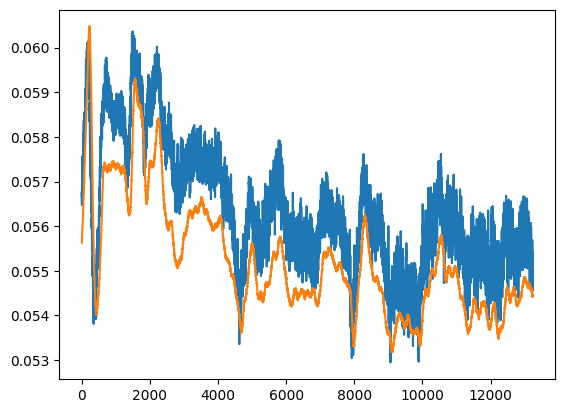

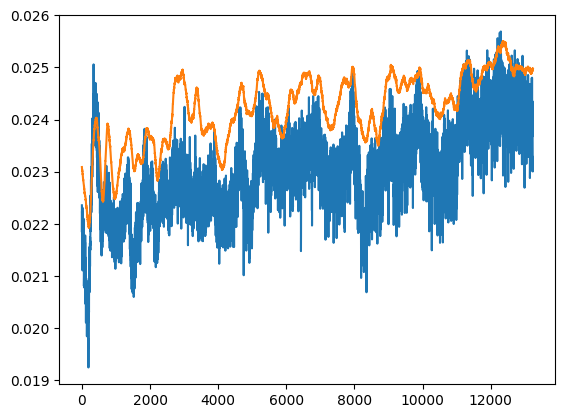

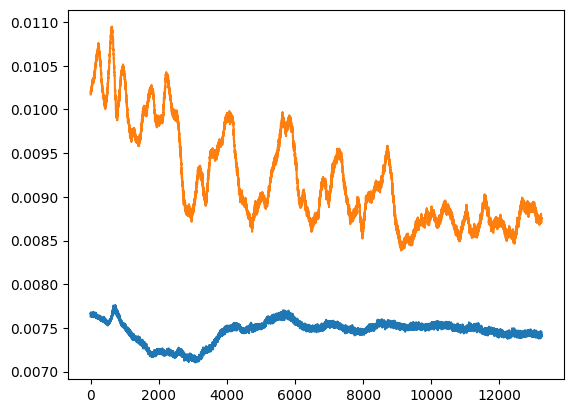

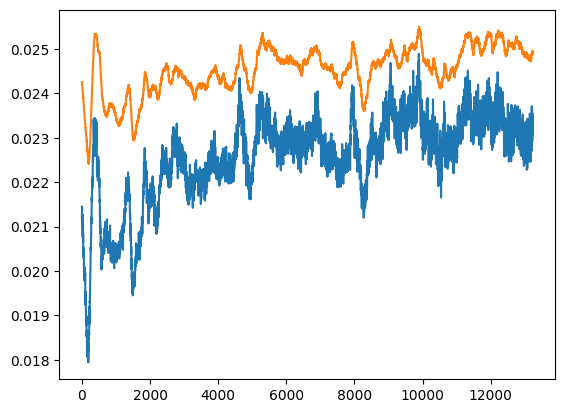

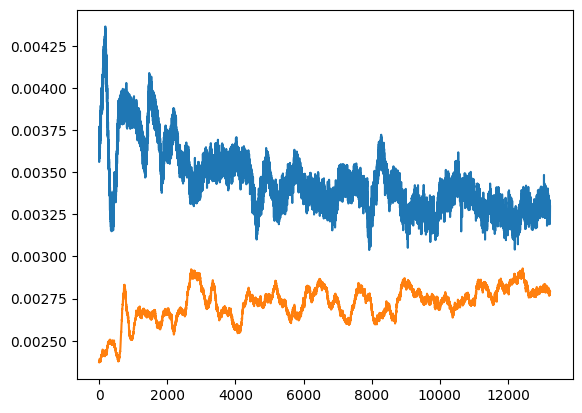

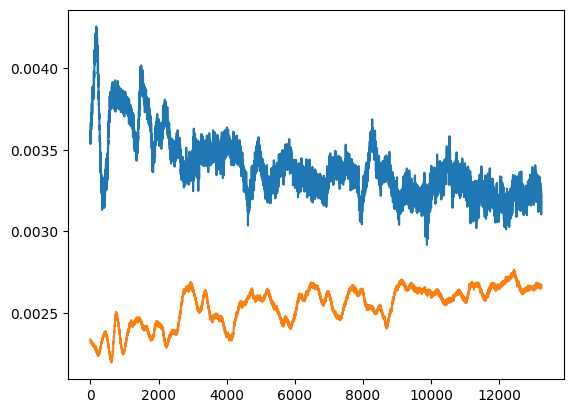

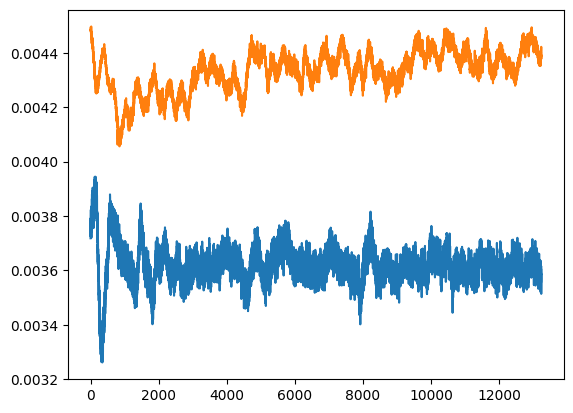

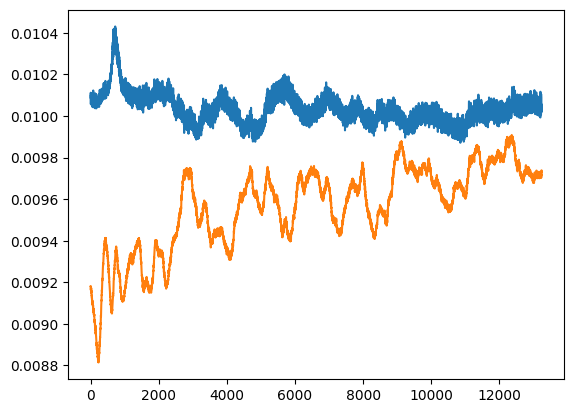

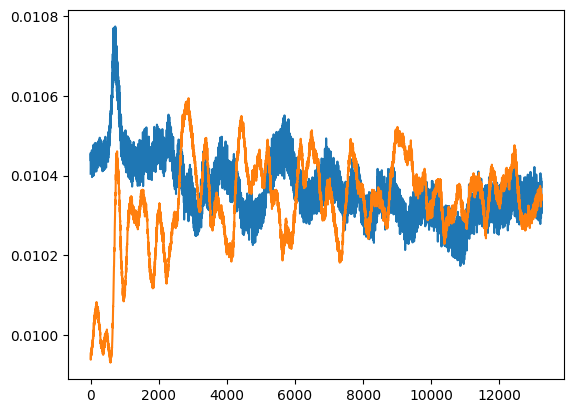

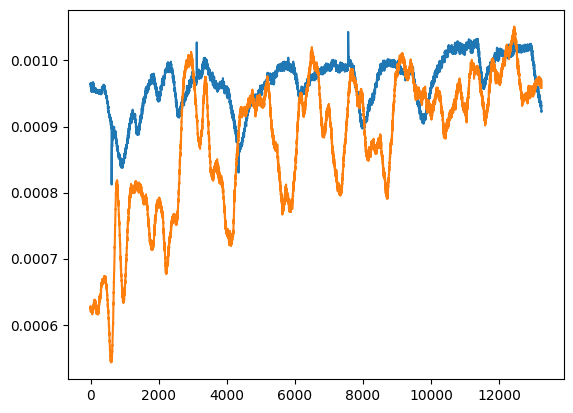

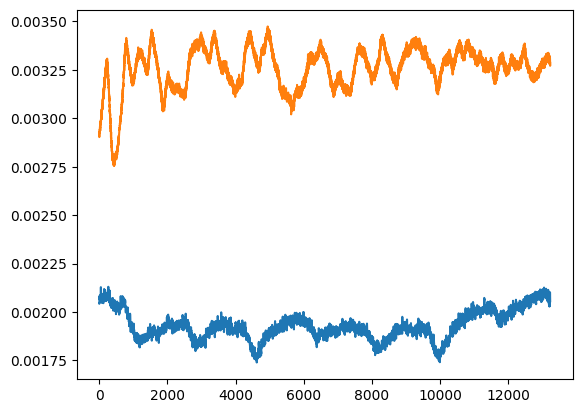

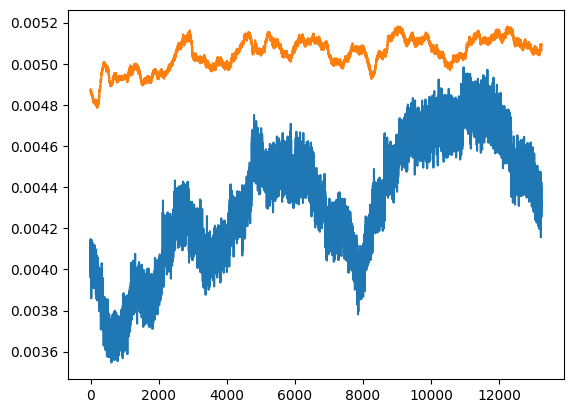

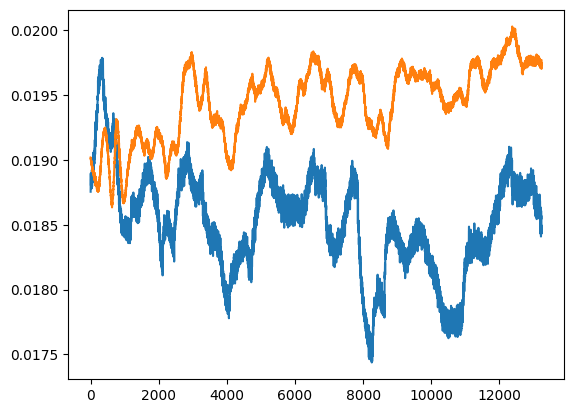

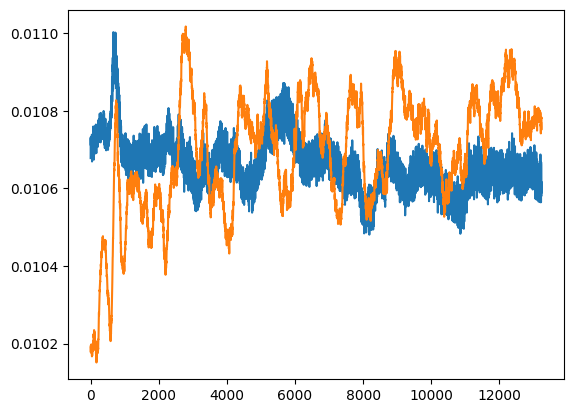

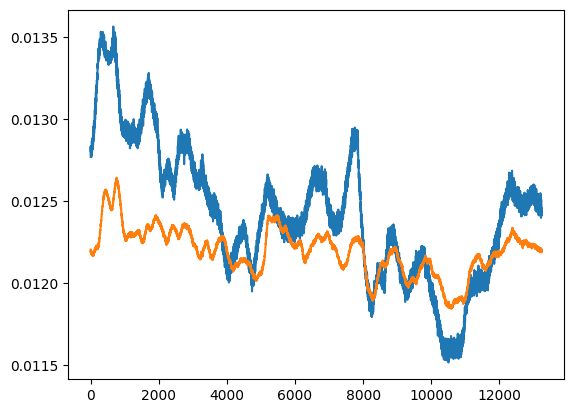

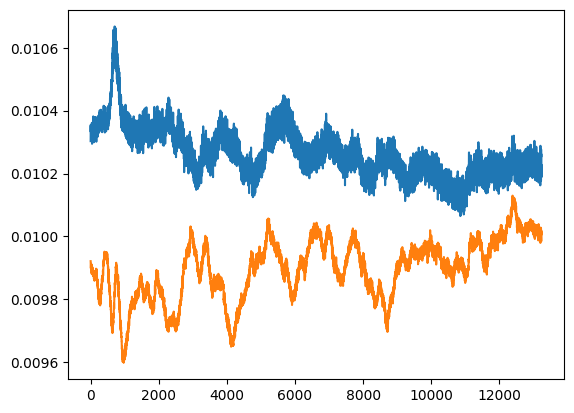

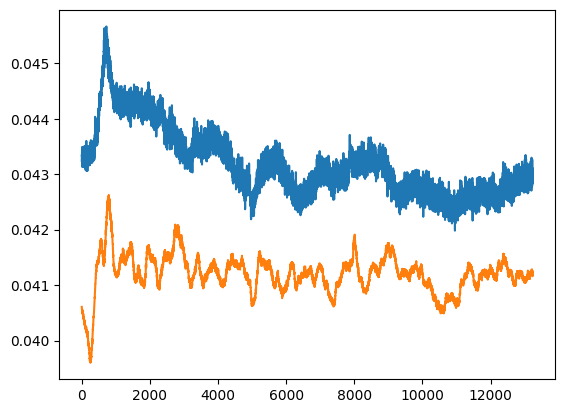

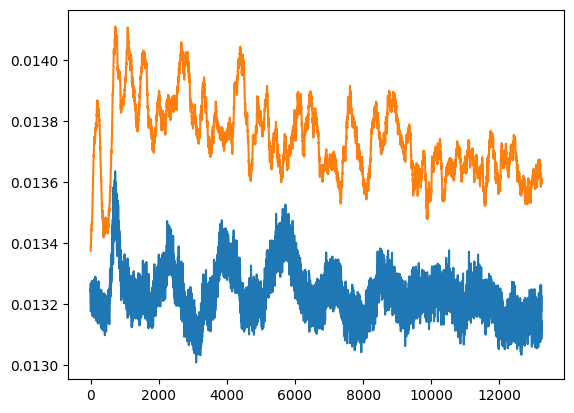

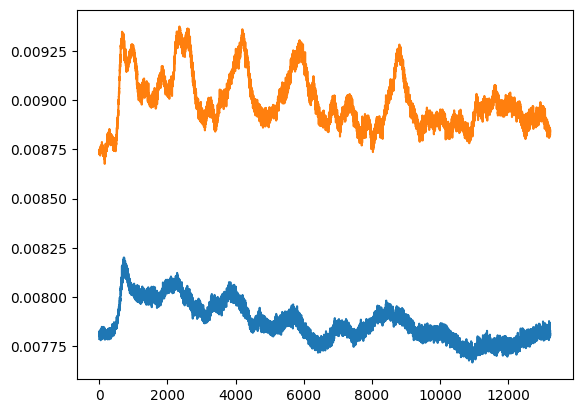

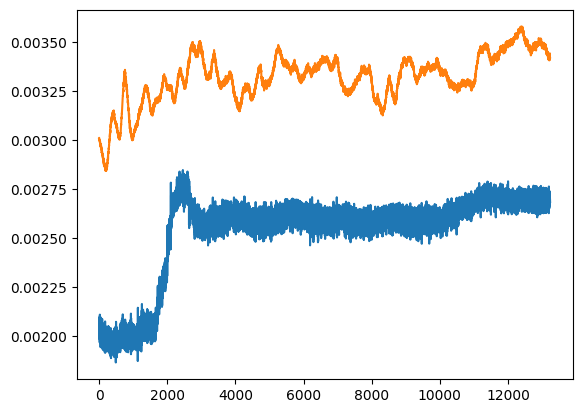

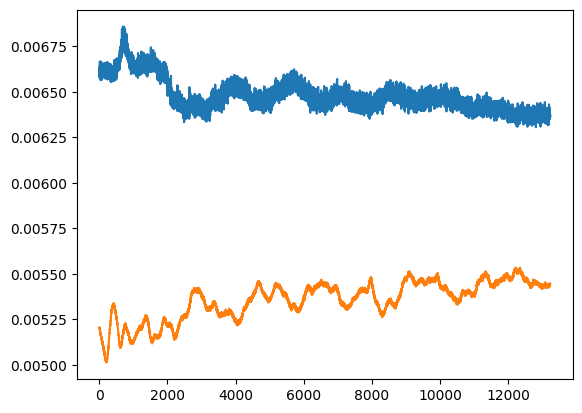

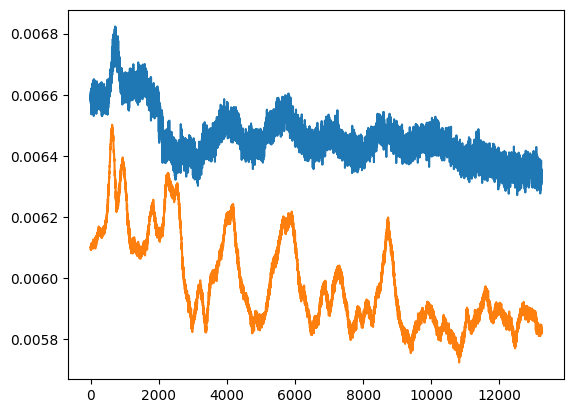

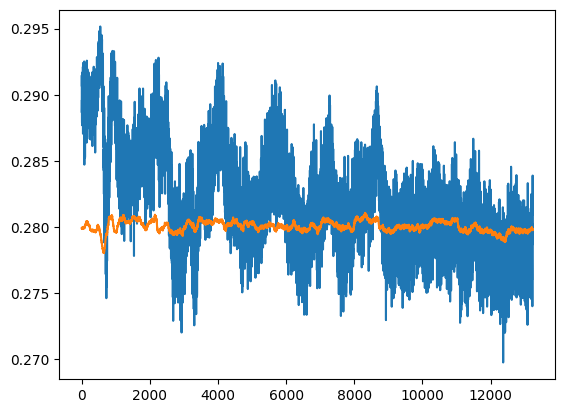

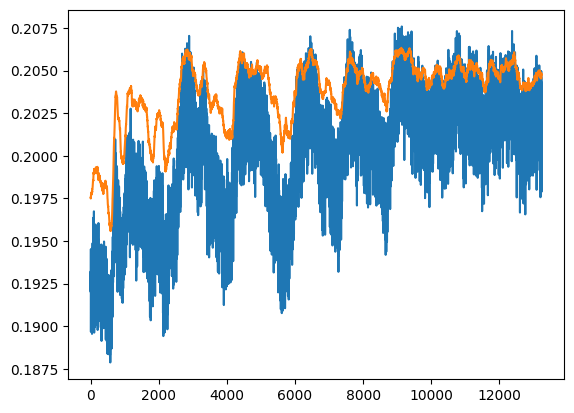

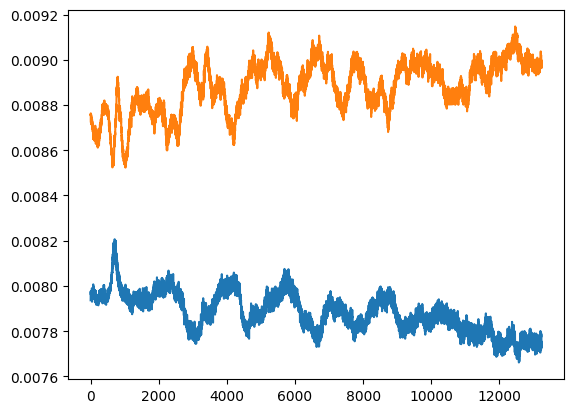

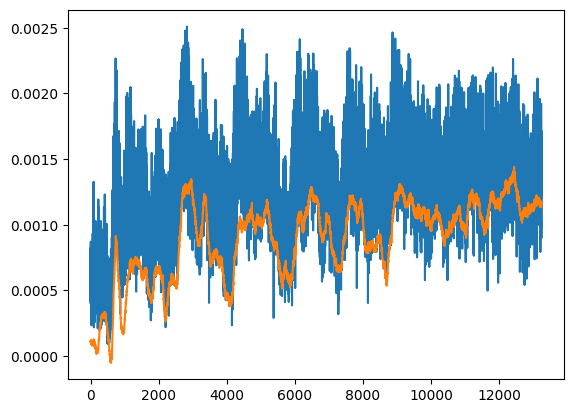

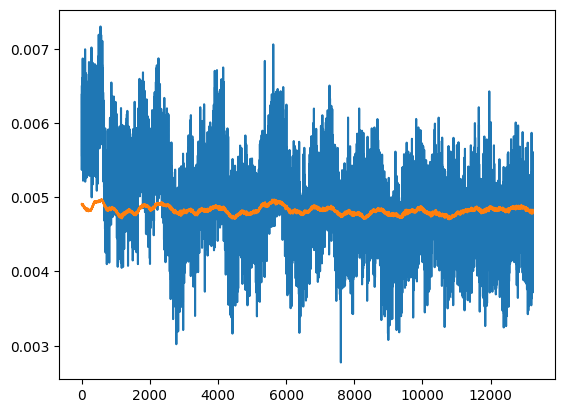

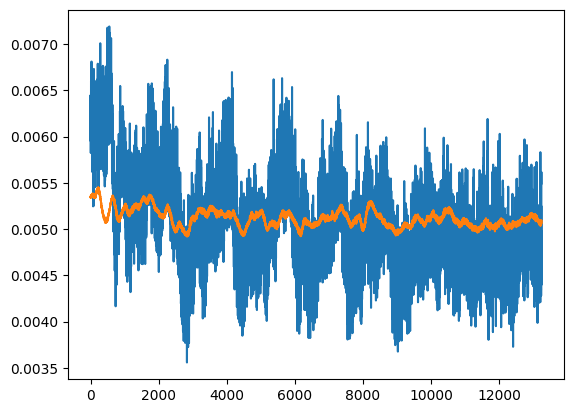

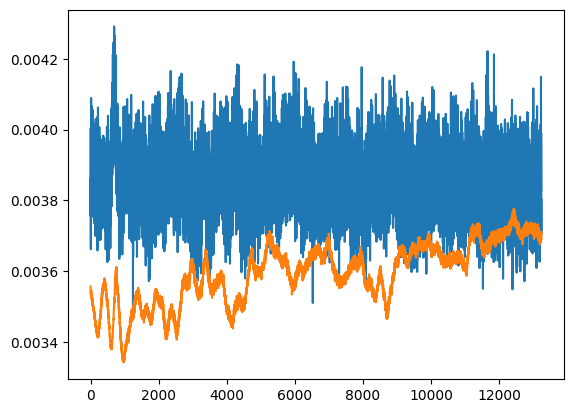

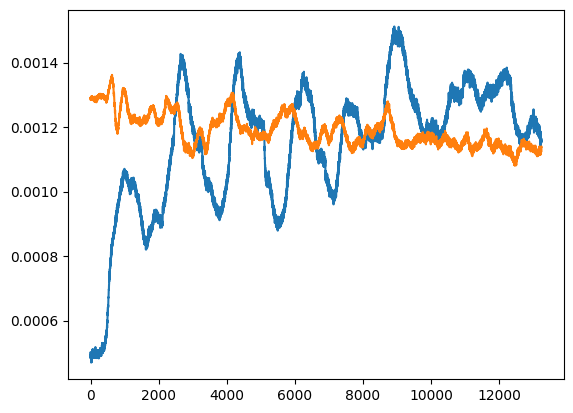

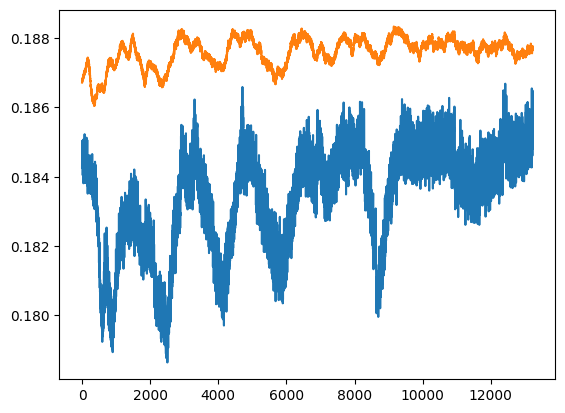

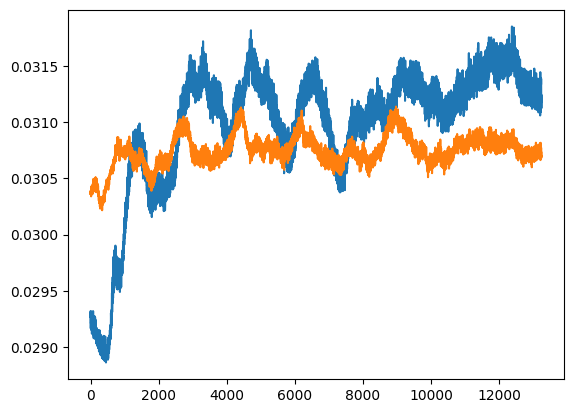

In [10]:
# With 1D Convolution and both GATs
import matplotlib.pyplot as plt

for i in range(window.shape[1]):
    plt.plot(targets[:,i])
    plt.plot(preds[:,i])
    plt.show()

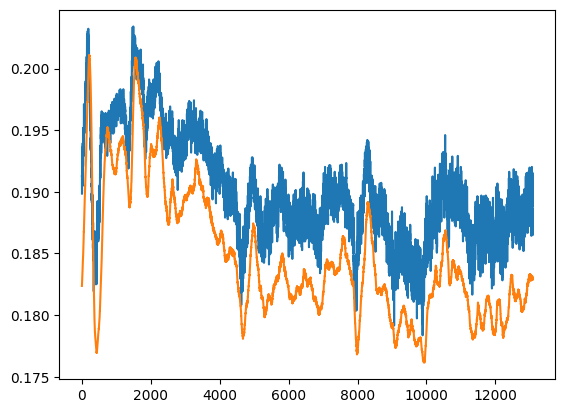

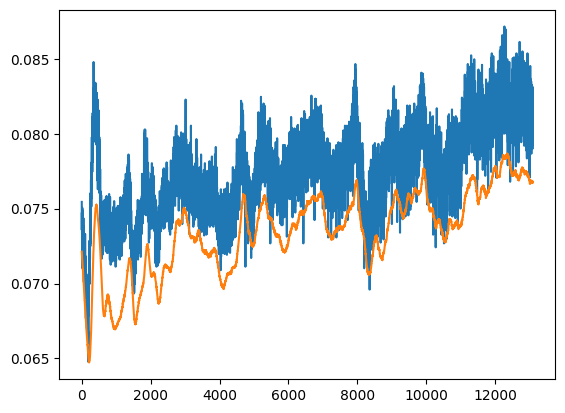

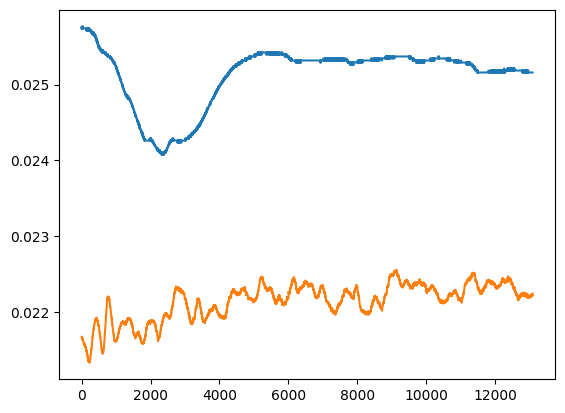

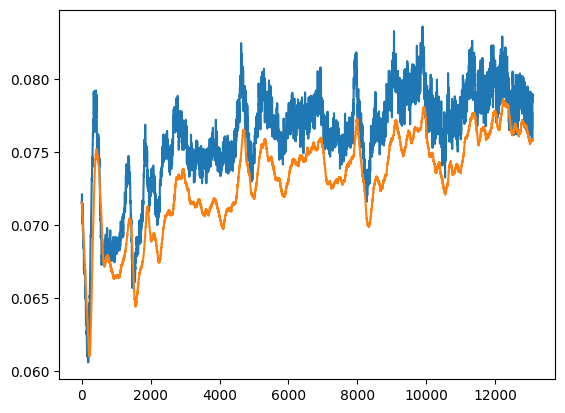

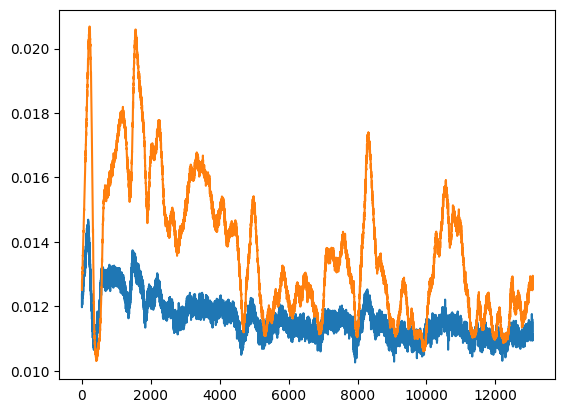

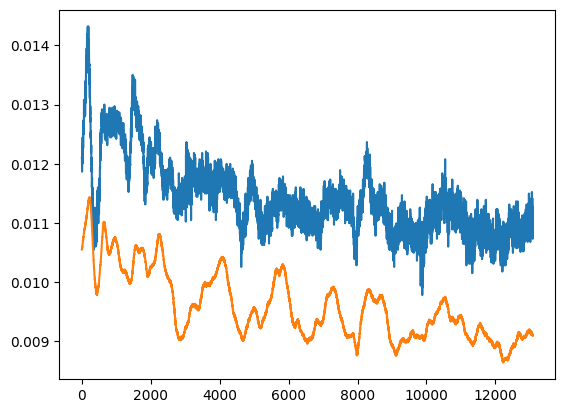

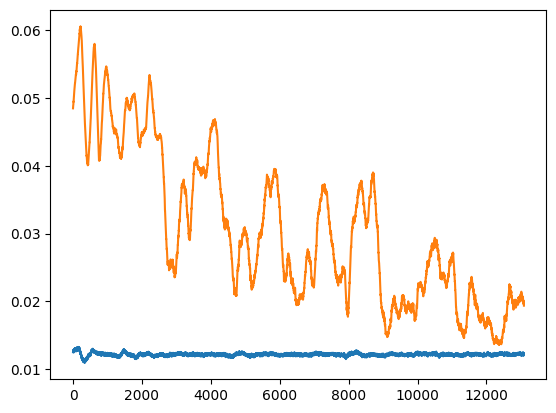

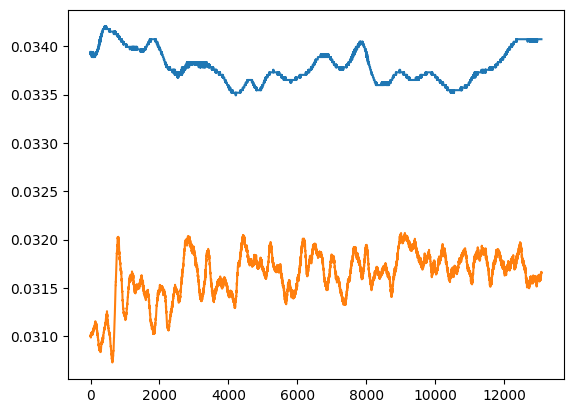

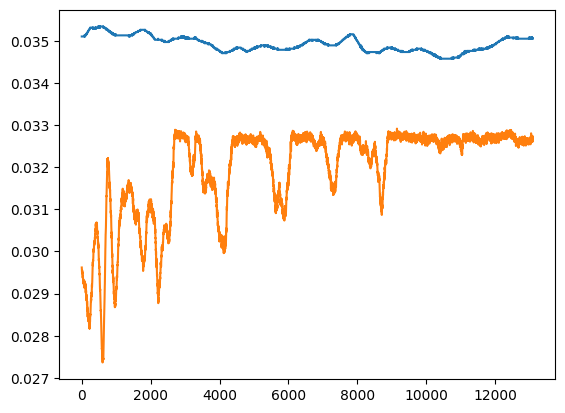

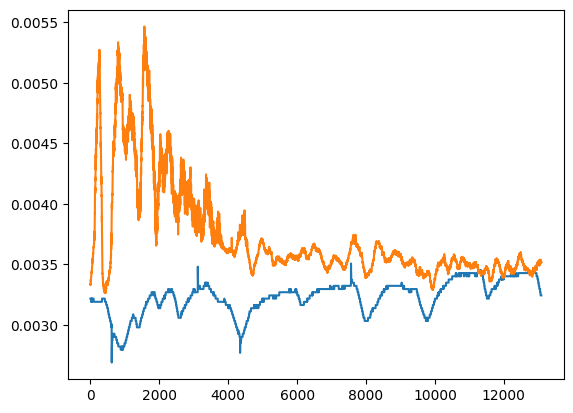

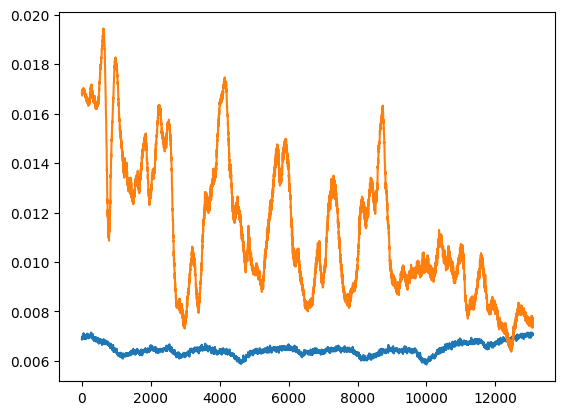

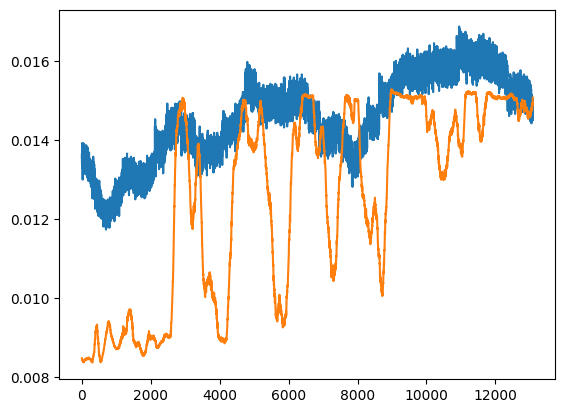

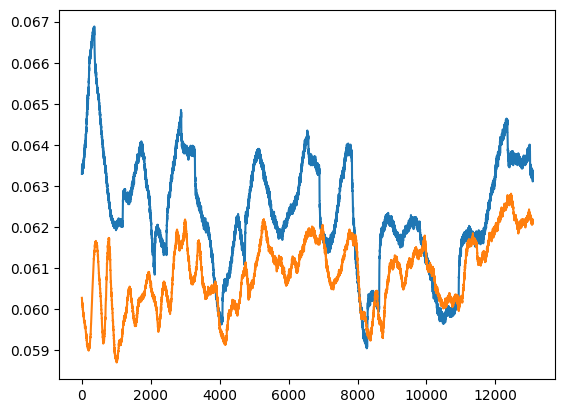

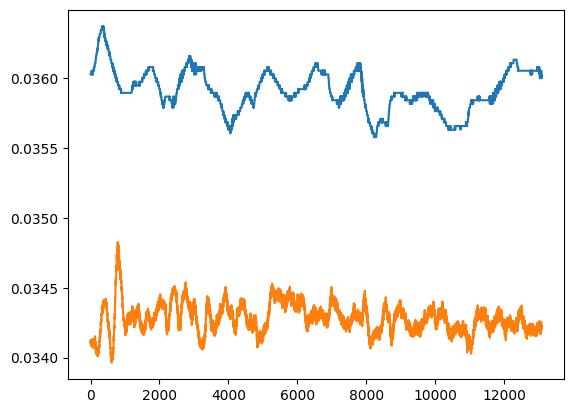

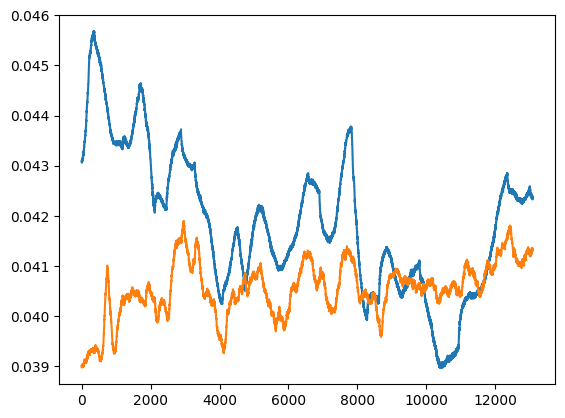

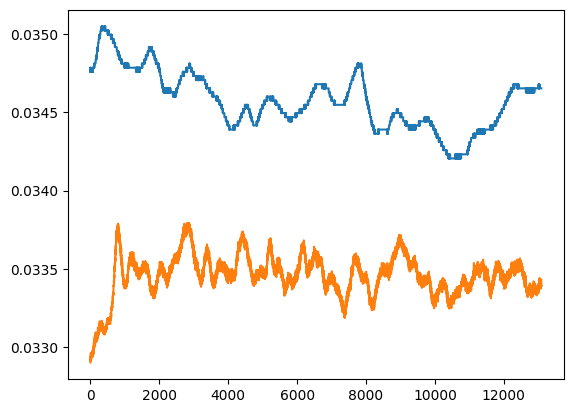

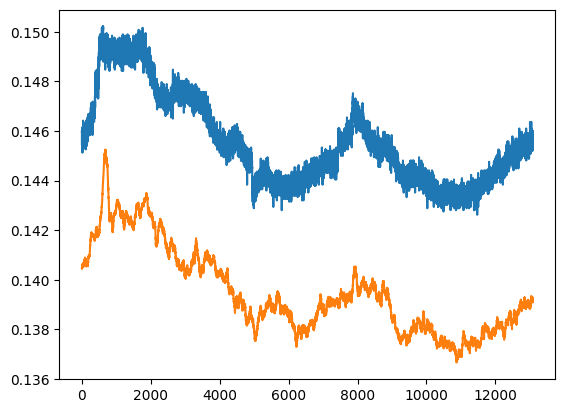

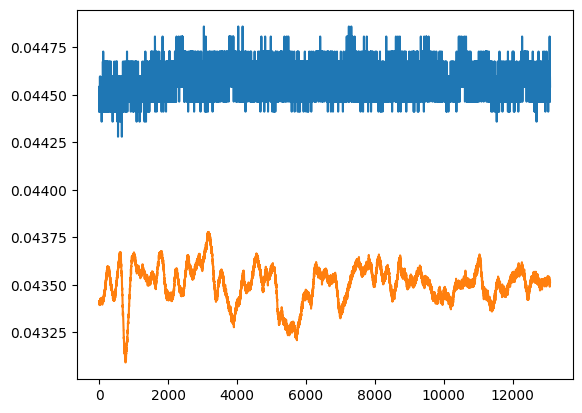

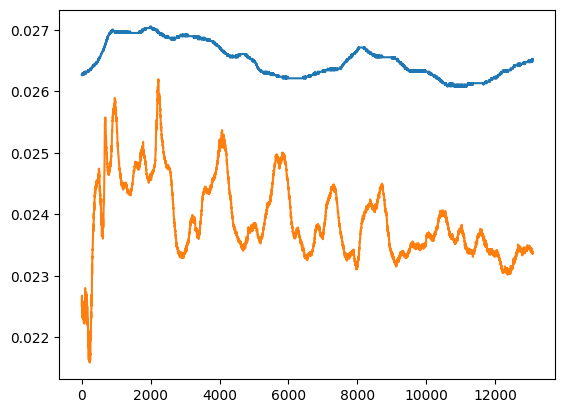

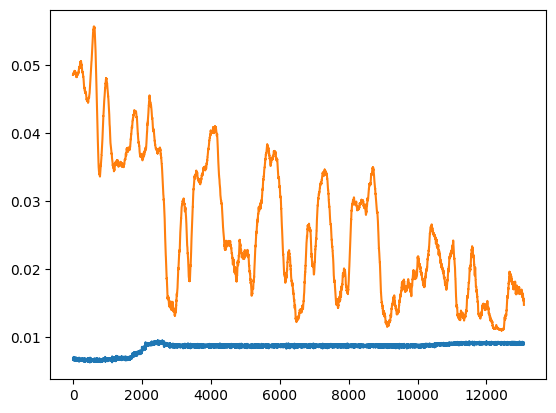

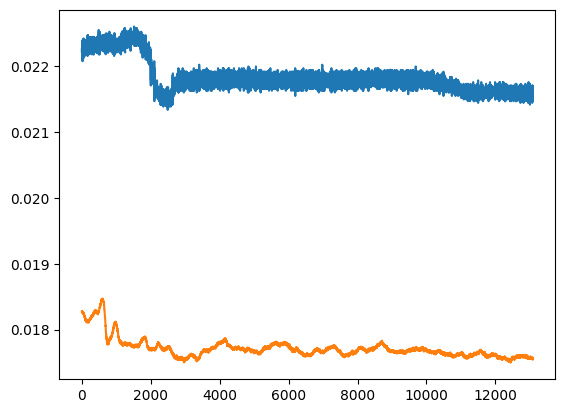

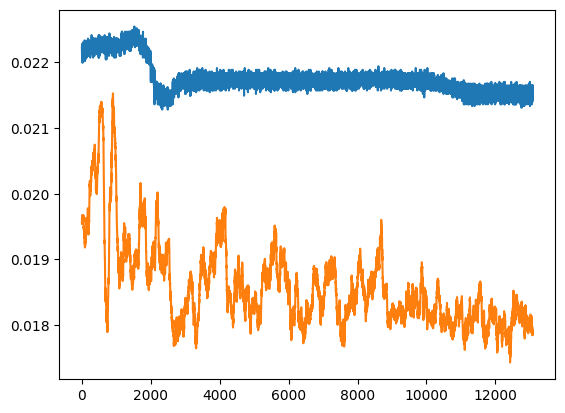

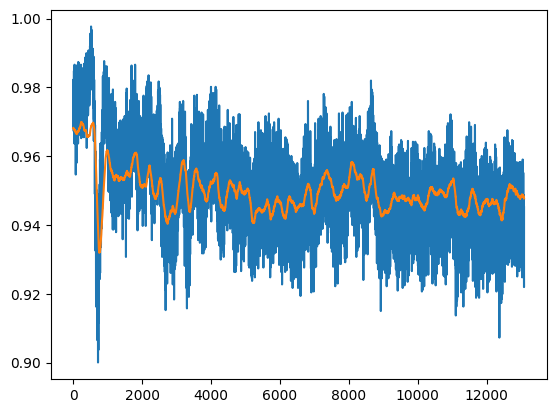

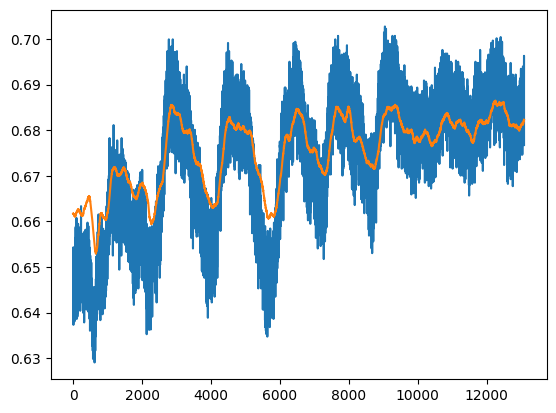

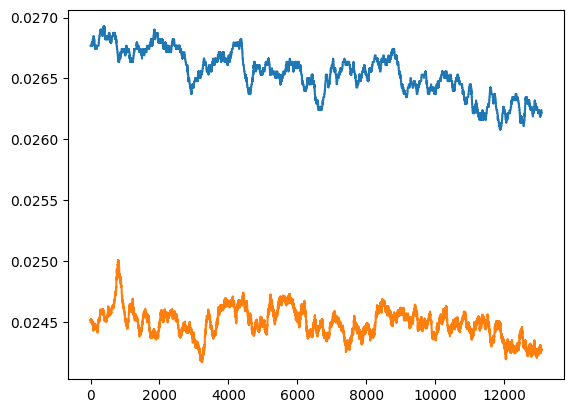

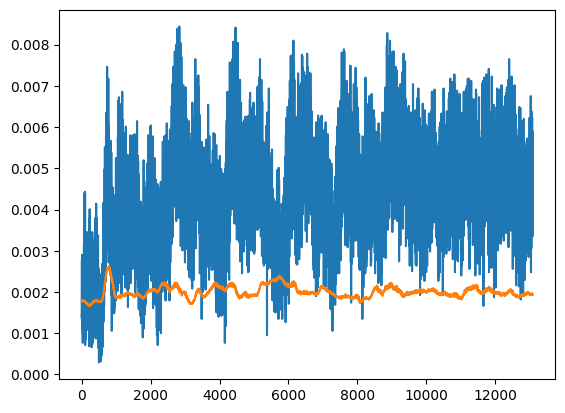

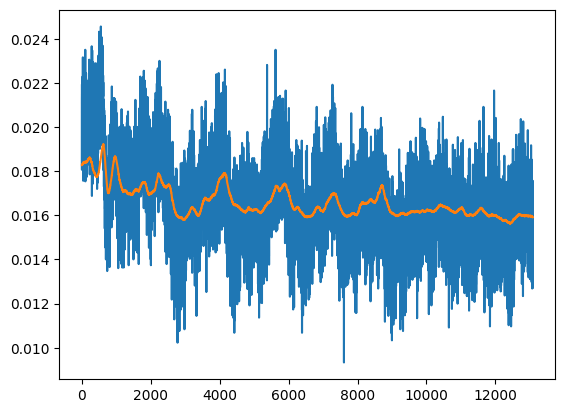

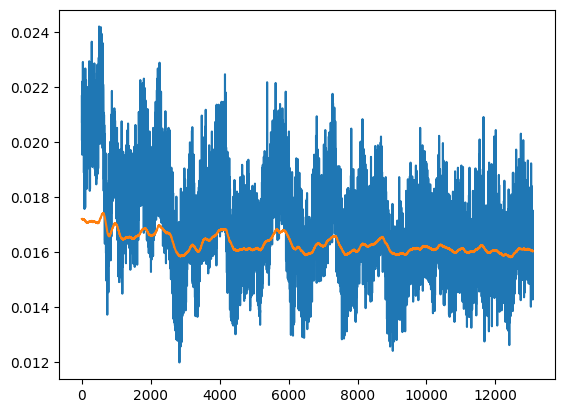

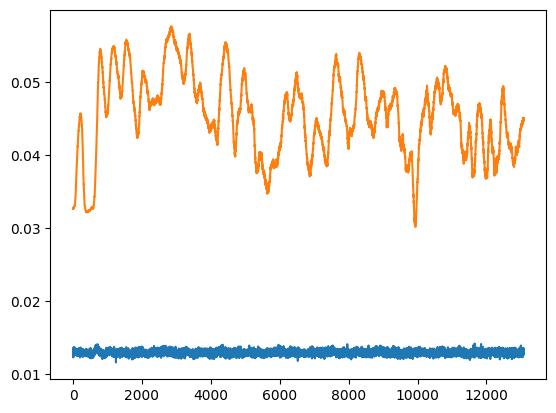

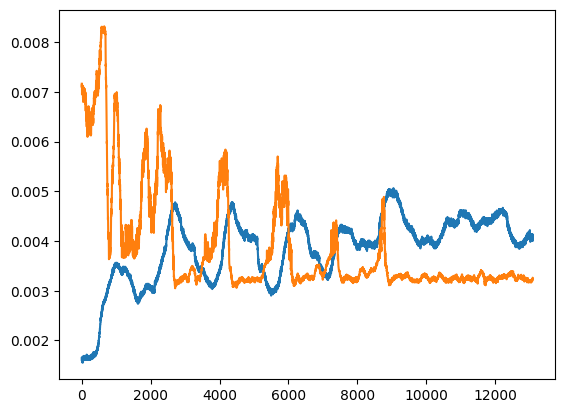

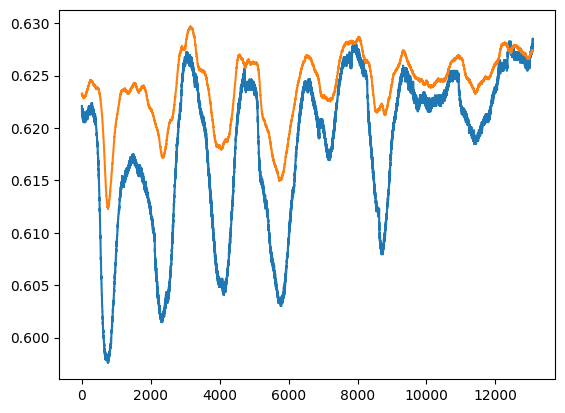

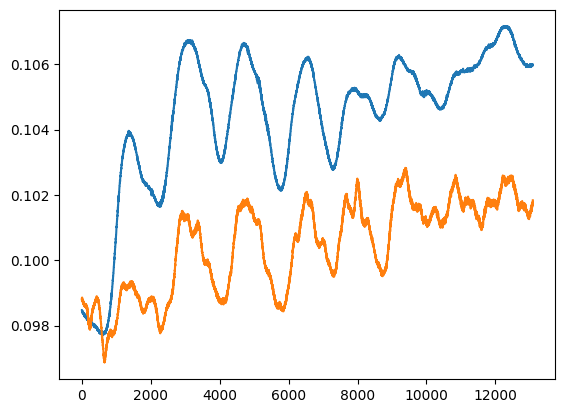

In [24]:
# With 1D Convolution and both GATs
import matplotlib.pyplot as plt

for i in range(window.shape[1]):
    plt.plot(targets[:,i])
    plt.plot(preds[:,i])
    plt.show()

In [19]:
# Eval model without GRU
model.eval()
preds = None
targets = None
for i,item in enumerate(test_dataloader):
    window, target = item
    window = window.squeeze()
    target = target.T.squeeze()
    x = model(window)
    
    if preds is None:
        preds = x.detach().numpy().reshape(-1)
    else:
        preds = np.vstack((preds,x.detach().numpy().reshape(-1)))
    if targets is None:
        targets = target.detach().numpy().reshape(-1)
    else:
        targets = np.vstack((targets,target.detach().numpy().reshape(-1)))
        

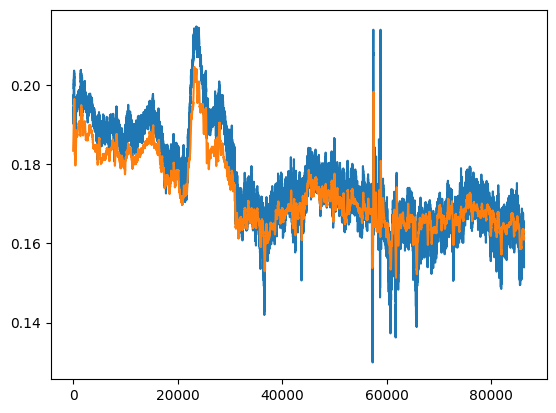

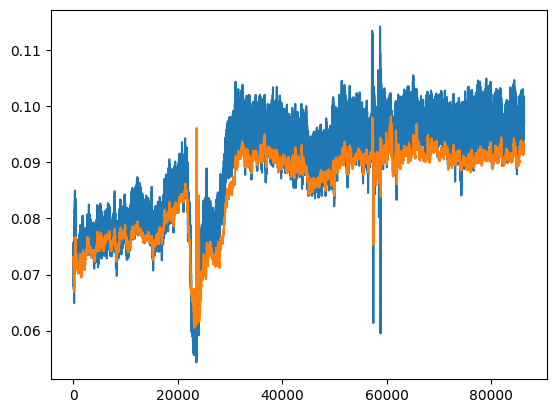

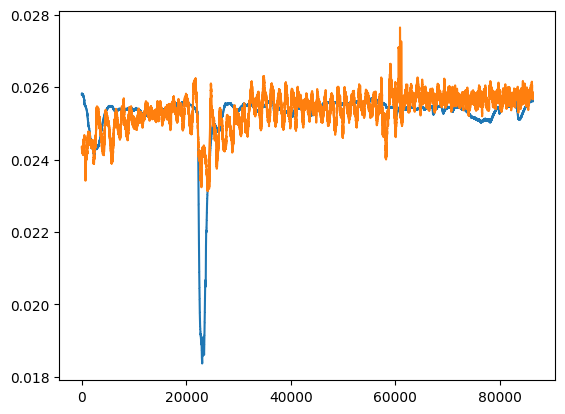

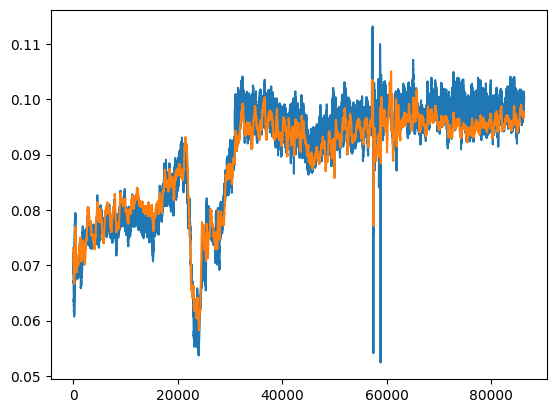

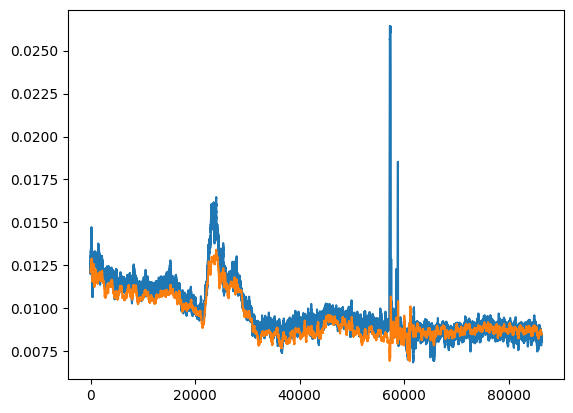

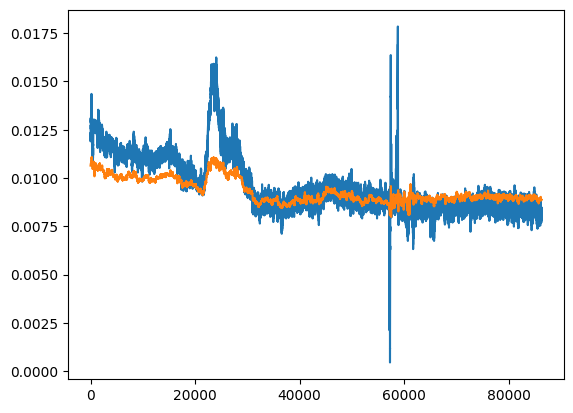

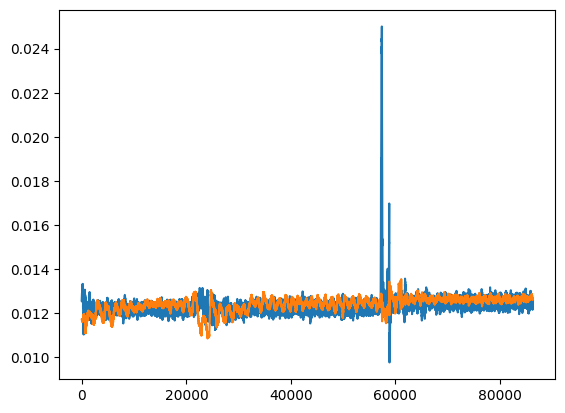

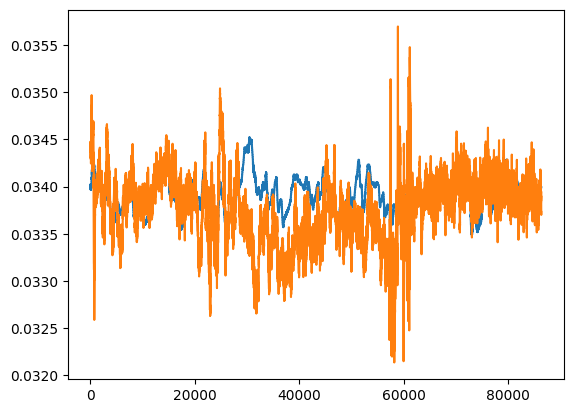

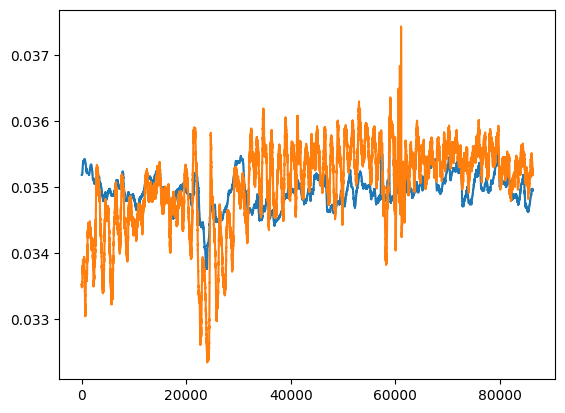

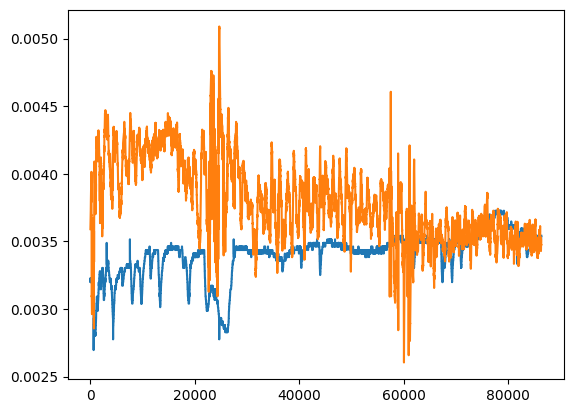

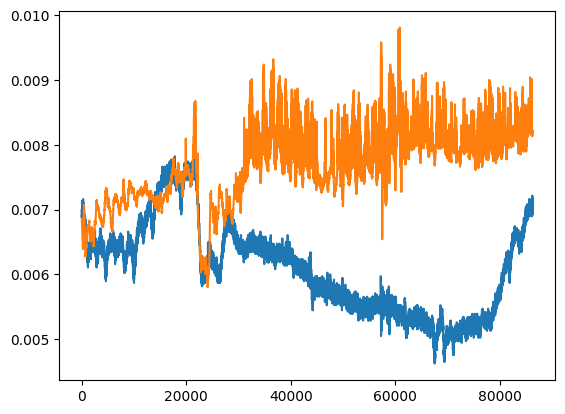

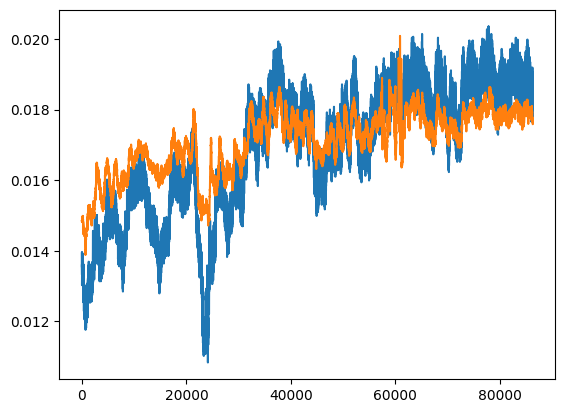

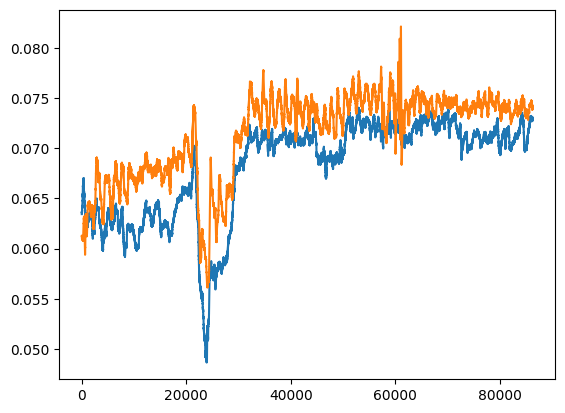

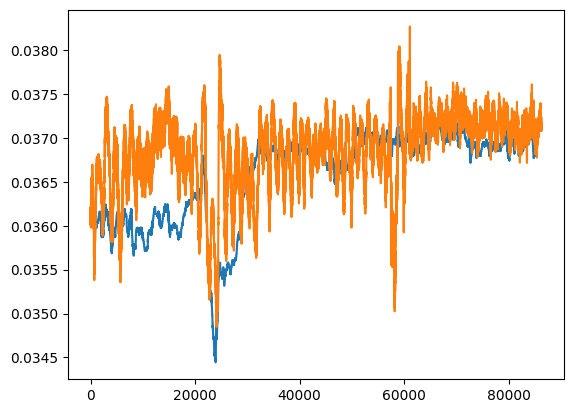

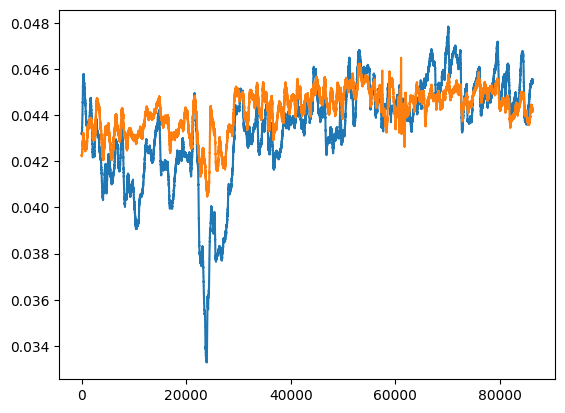

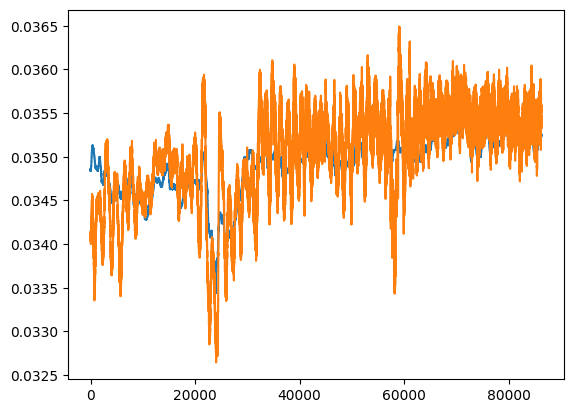

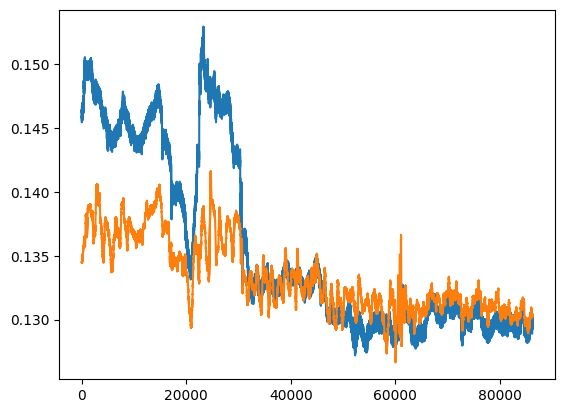

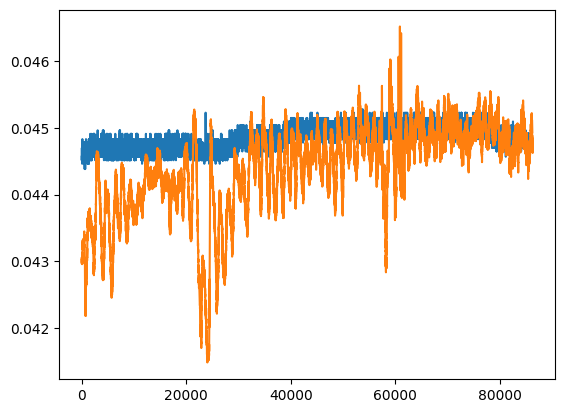

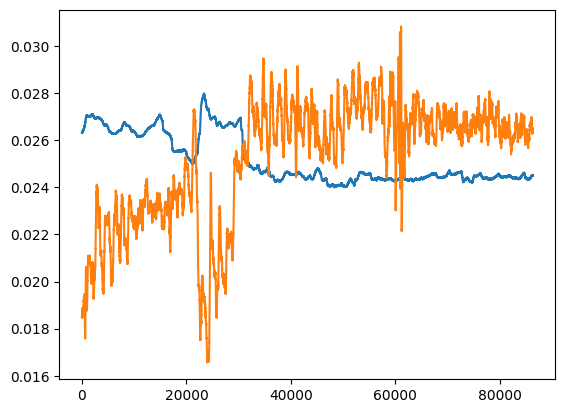

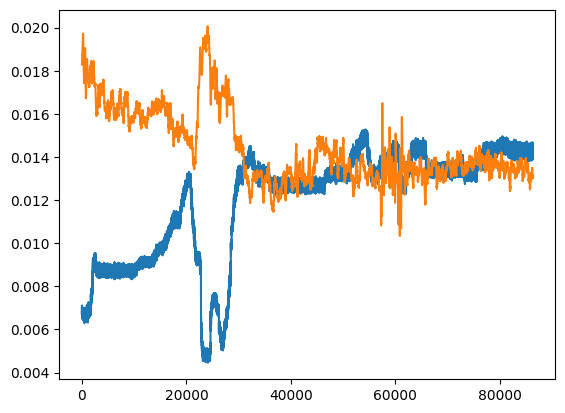

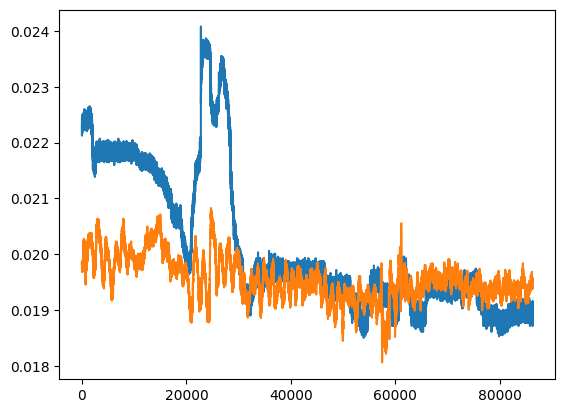

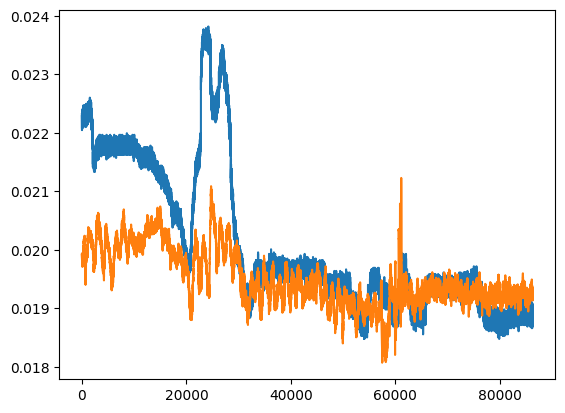

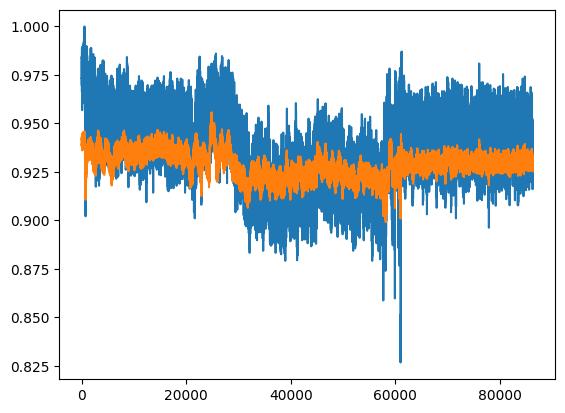

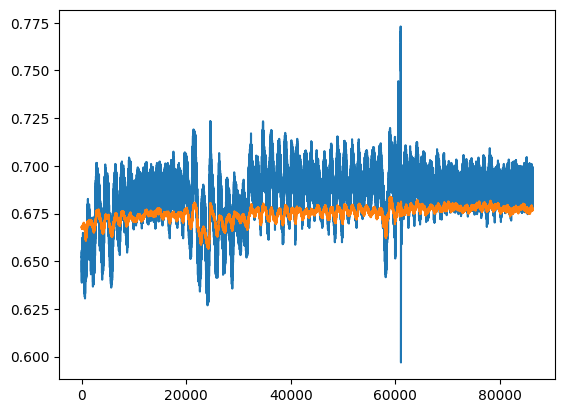

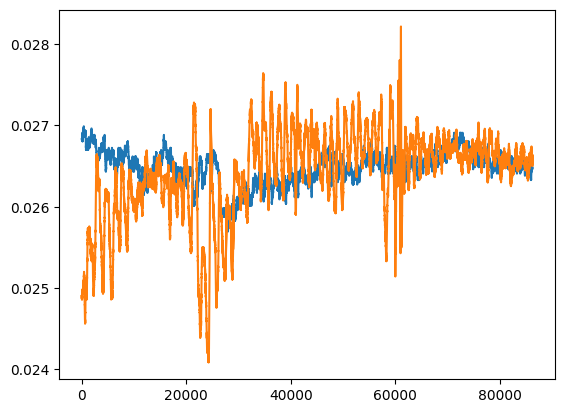

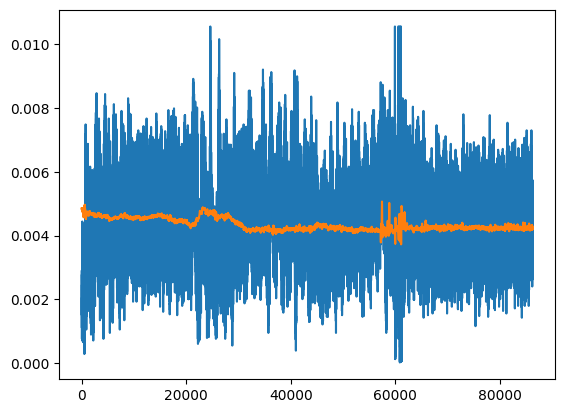

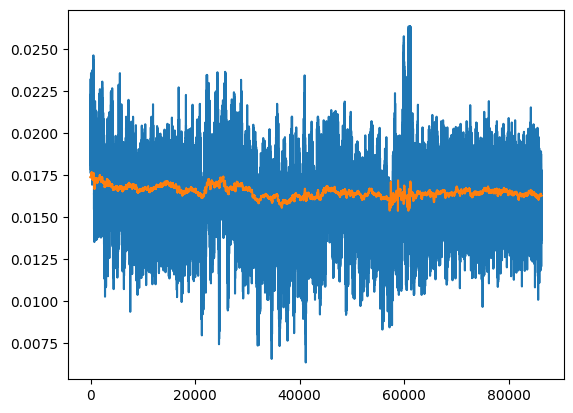

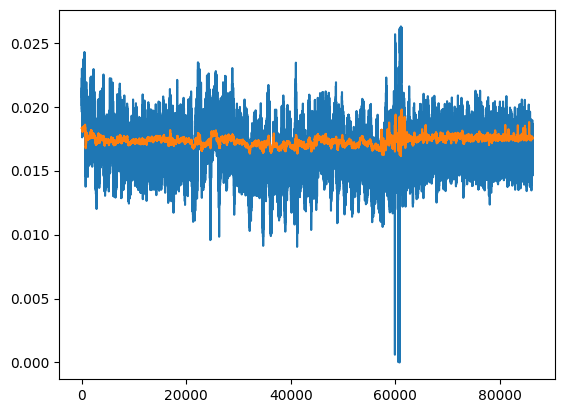

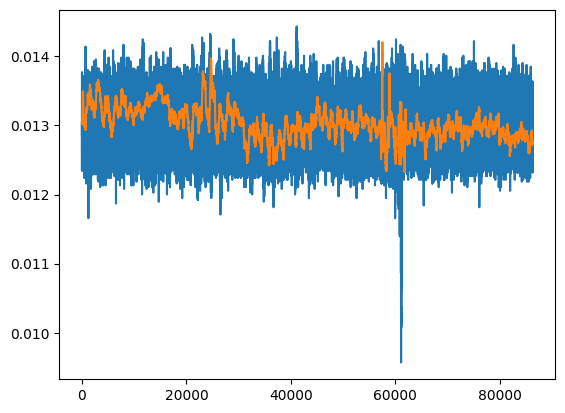

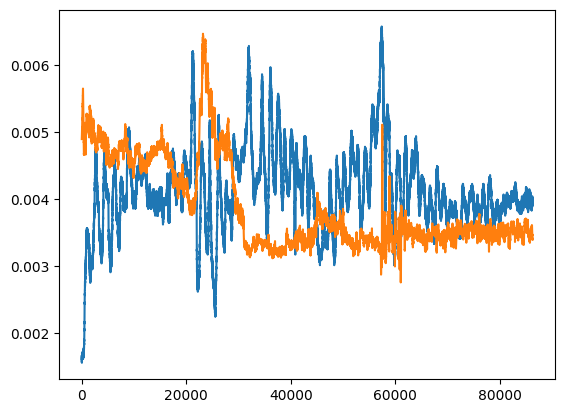

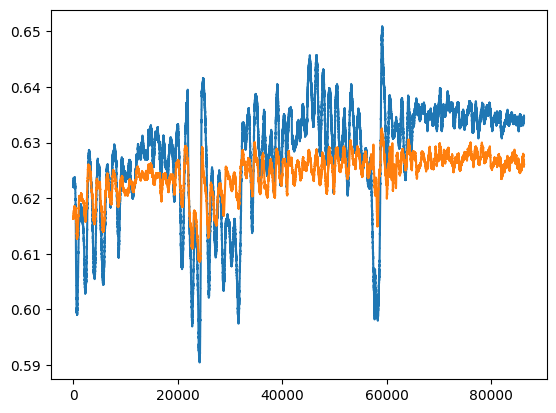

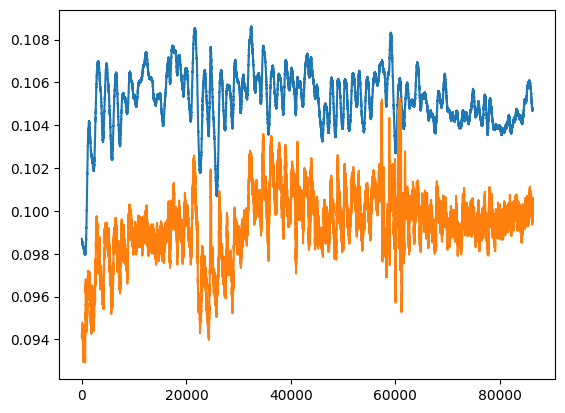

In [20]:
# With 1D Convolution and both GATs
import matplotlib.pyplot as plt

for i in range(window.shape[1]):
    plt.plot(targets[:,i])
    plt.plot(preds[:,i])
    plt.show()

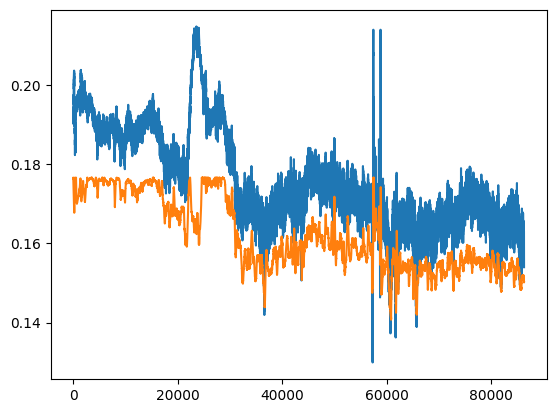

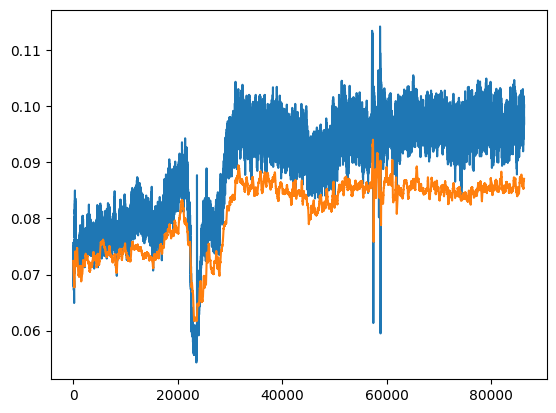

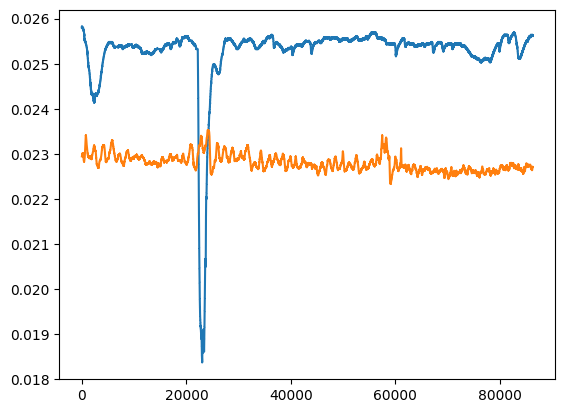

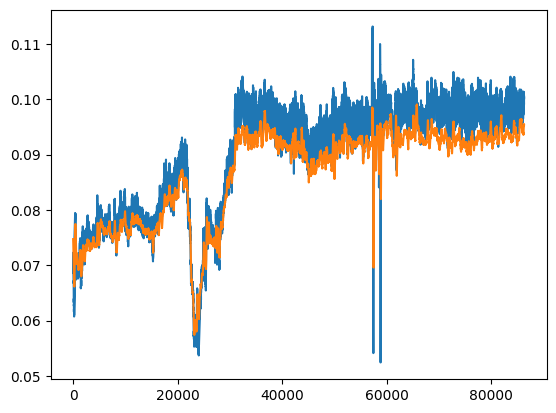

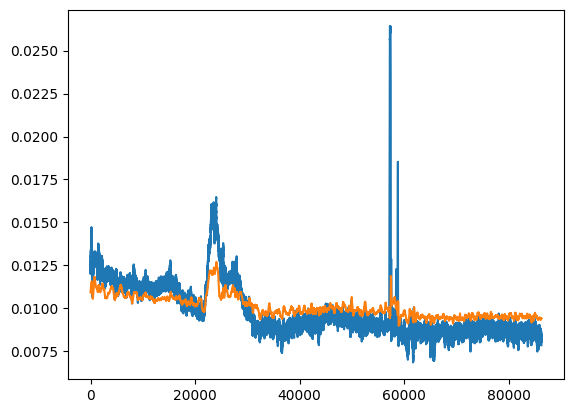

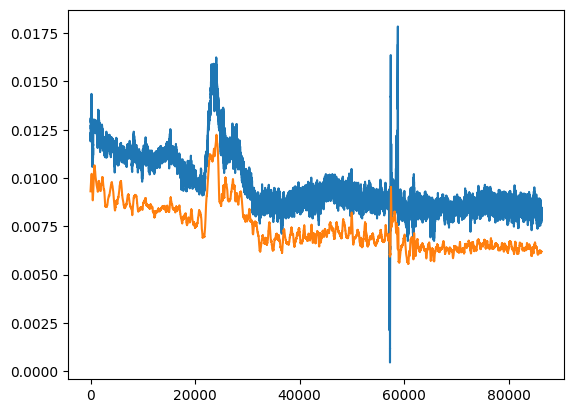

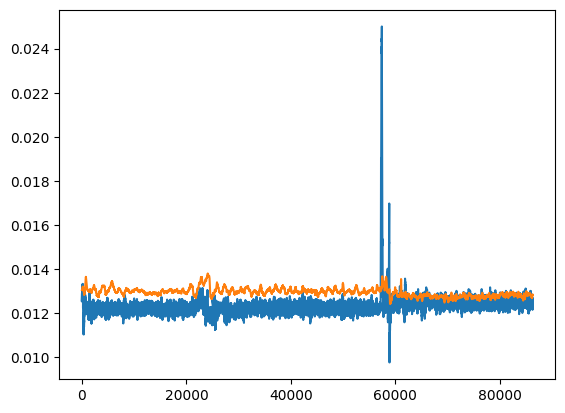

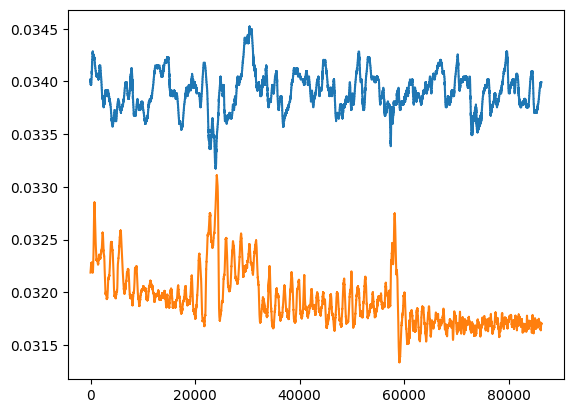

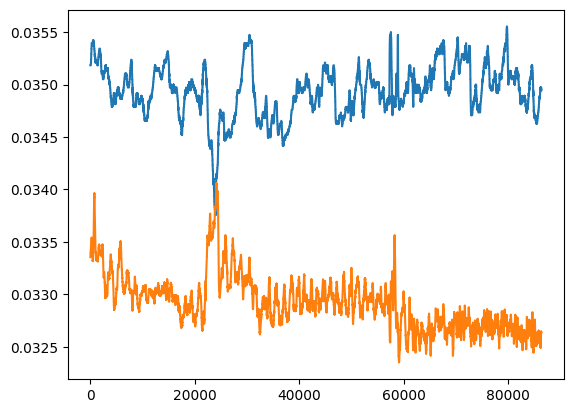

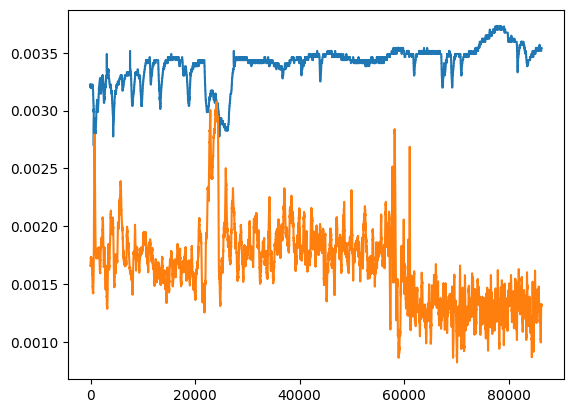

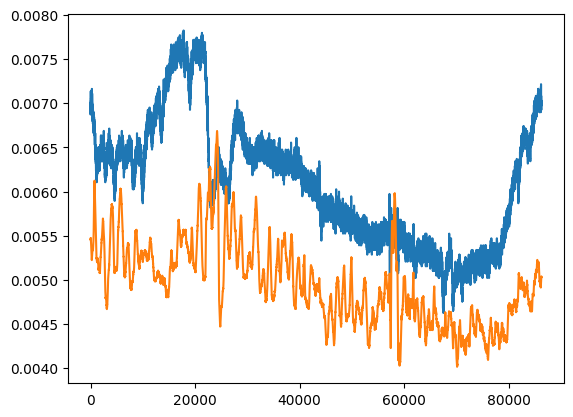

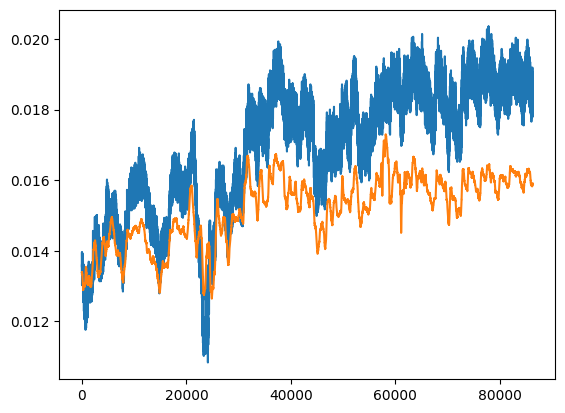

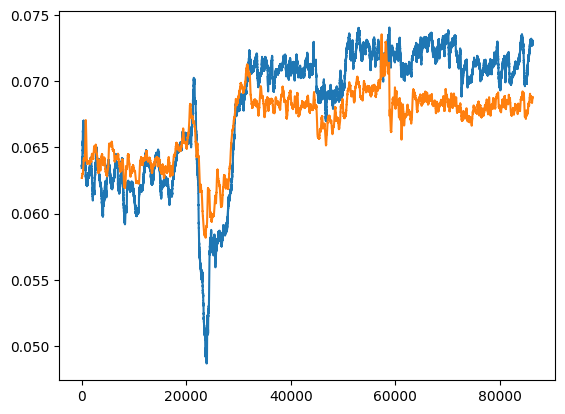

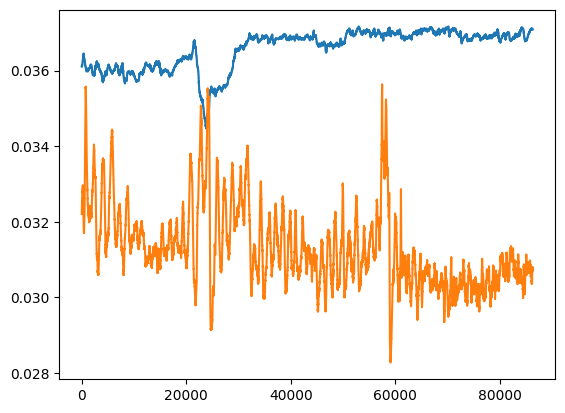

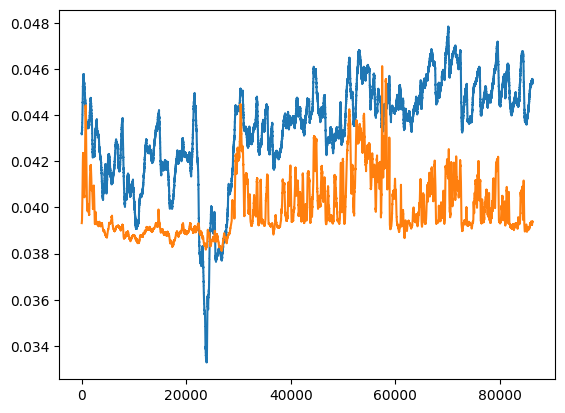

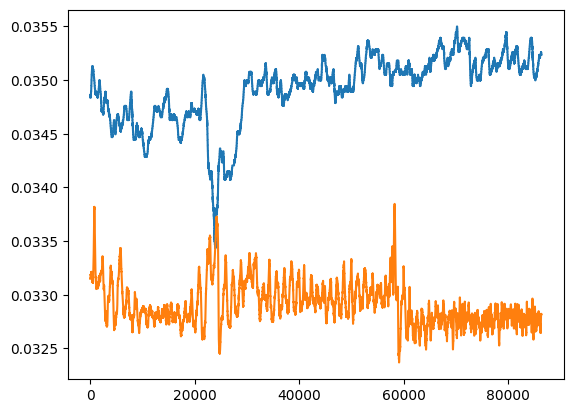

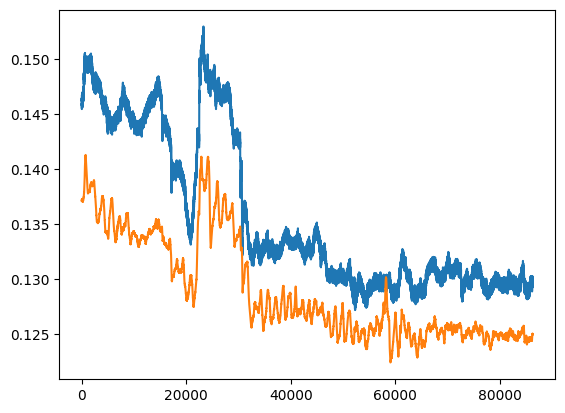

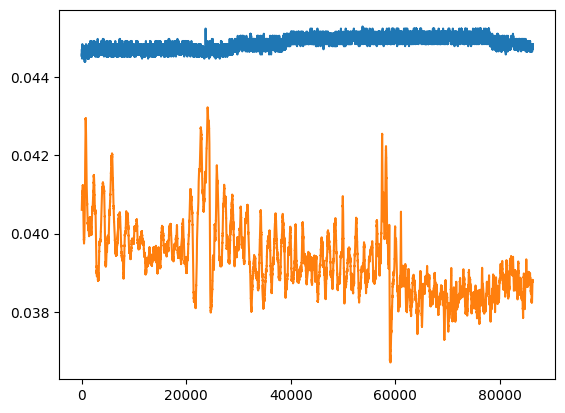

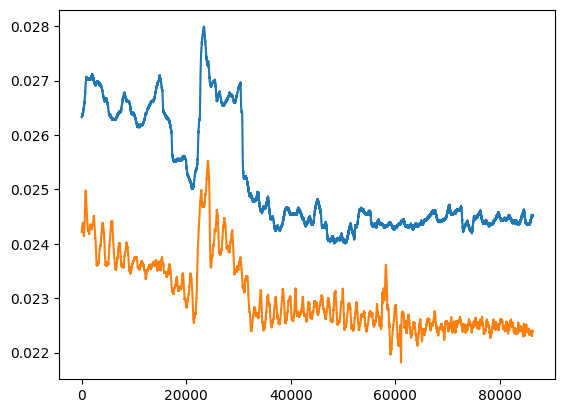

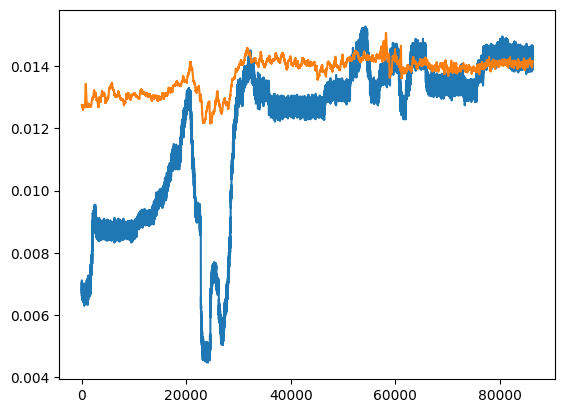

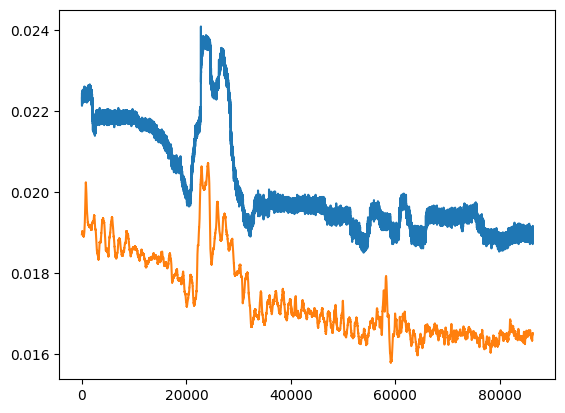

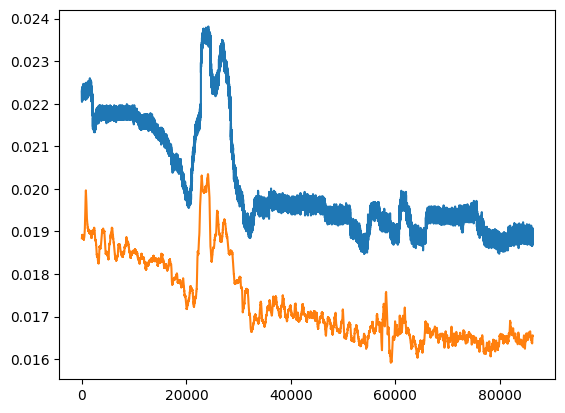

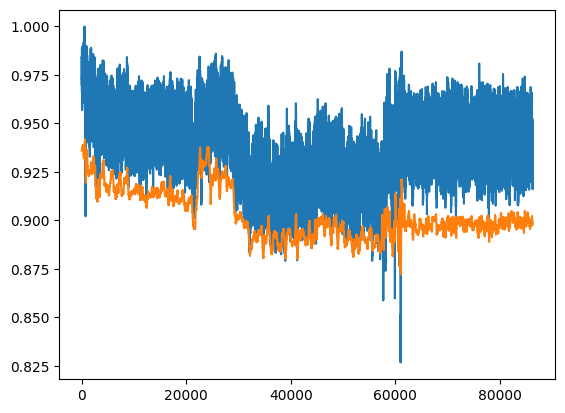

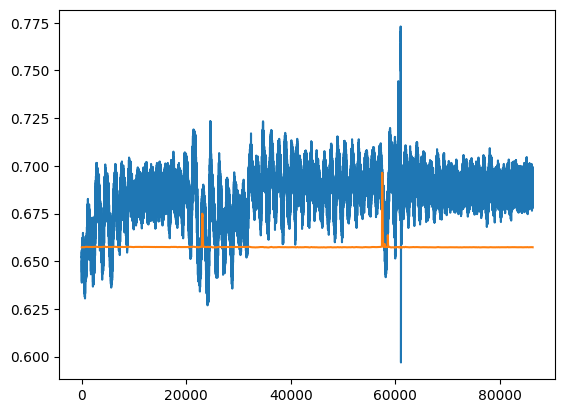

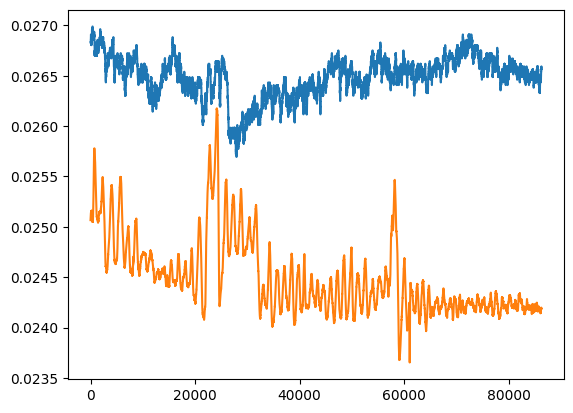

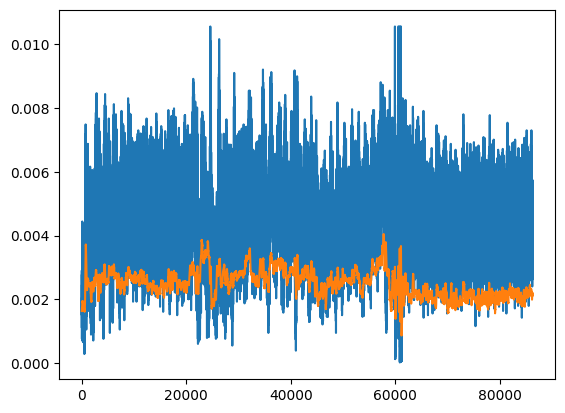

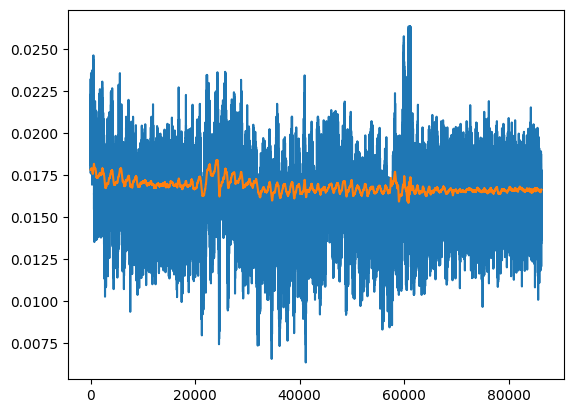

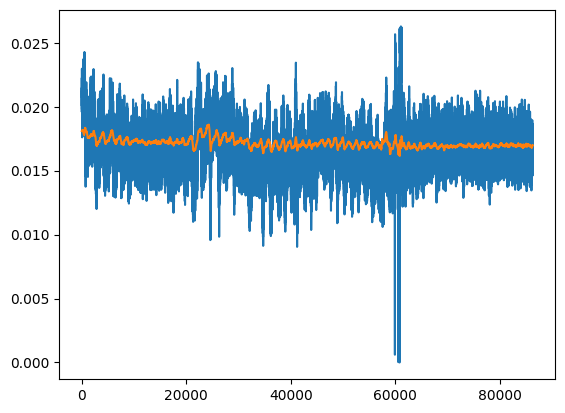

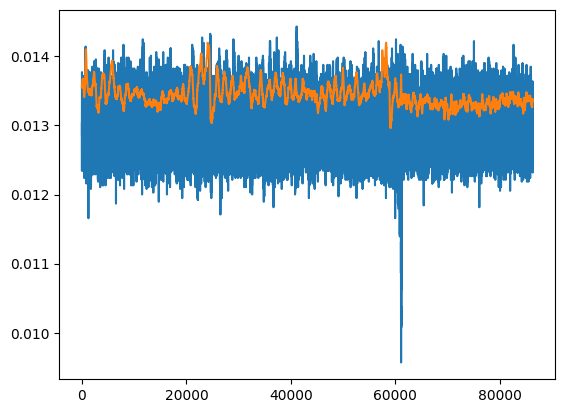

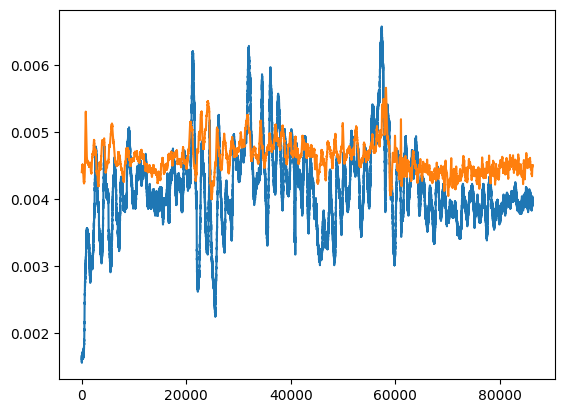

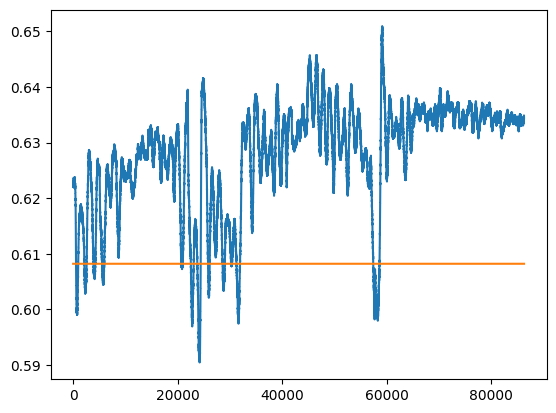

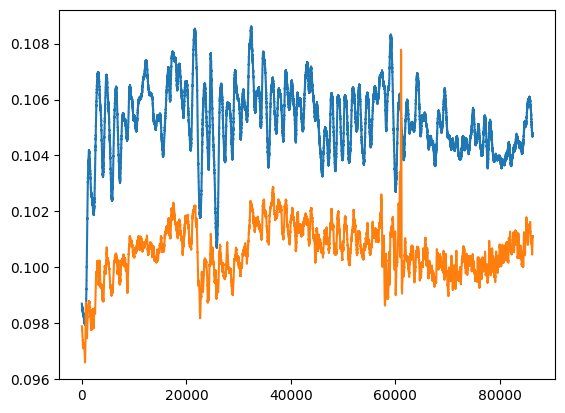

In [10]:
# With both GATs
import matplotlib.pyplot as plt

for i in range(window.shape[1]):
    plt.plot(targets[:,i])
    plt.plot(preds[:,i])
    plt.show()

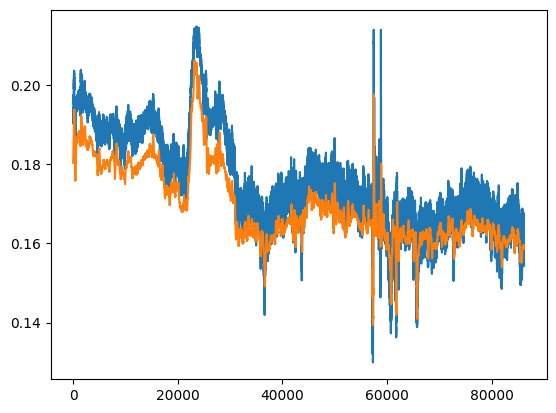

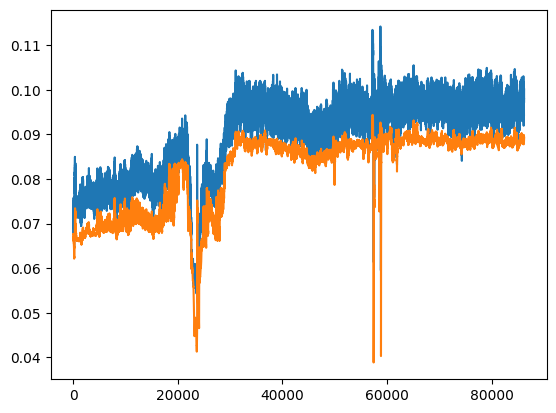

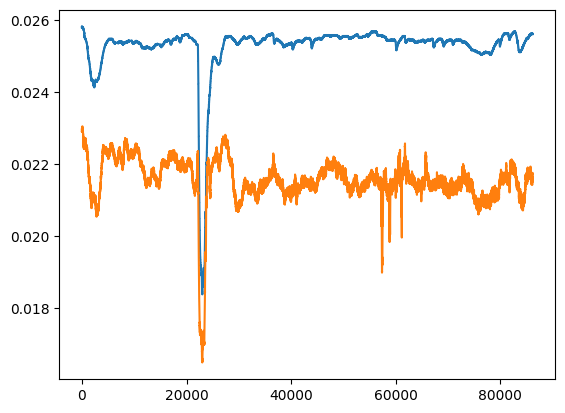

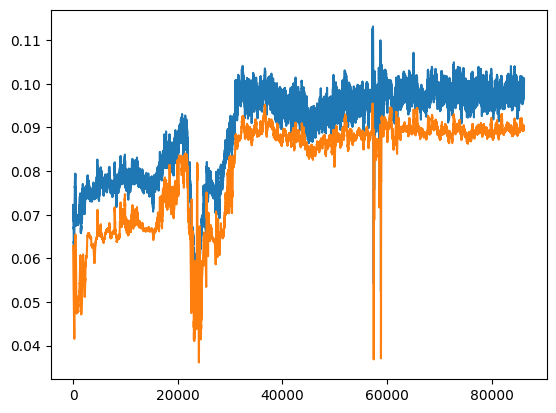

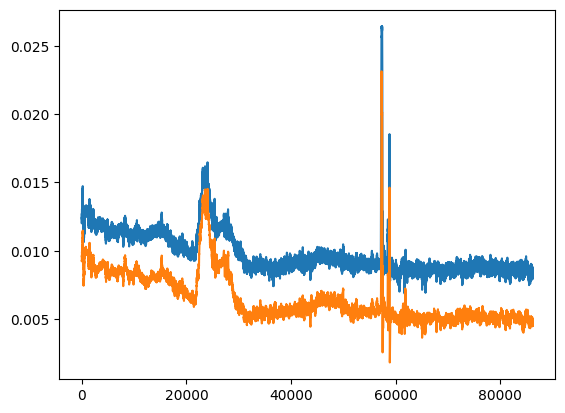

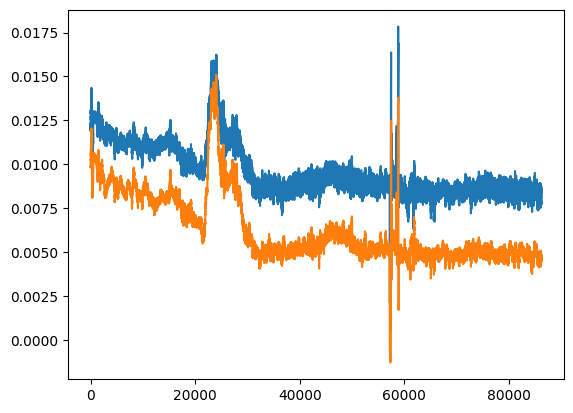

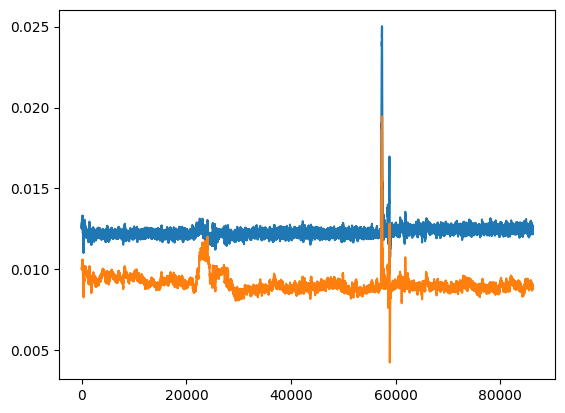

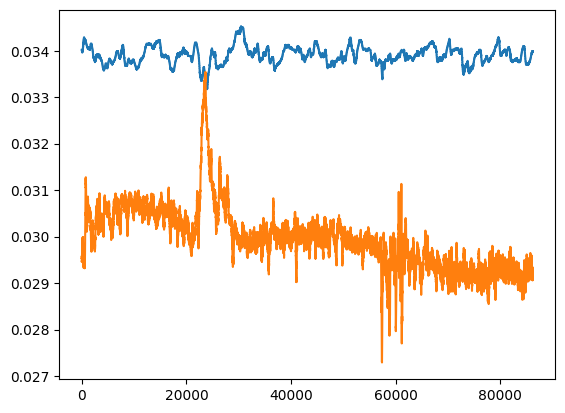

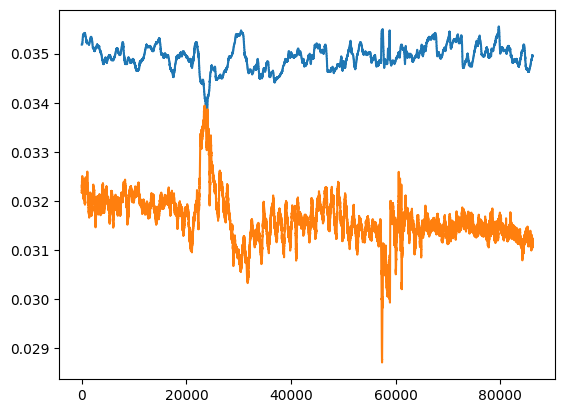

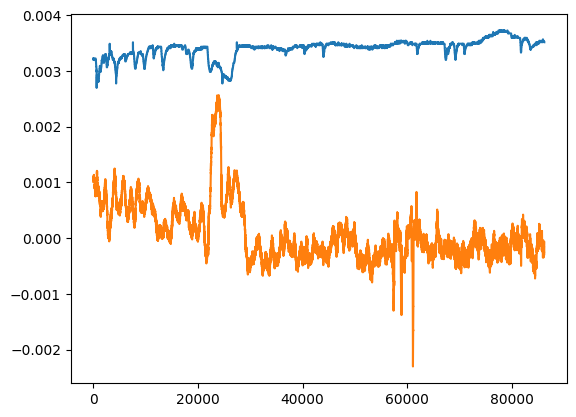

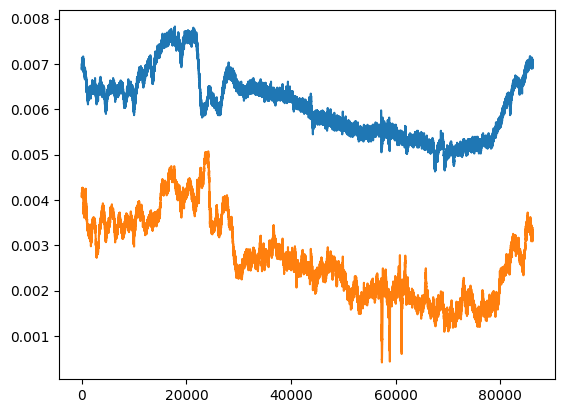

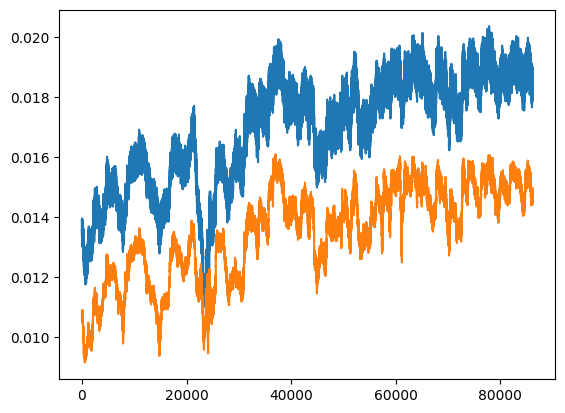

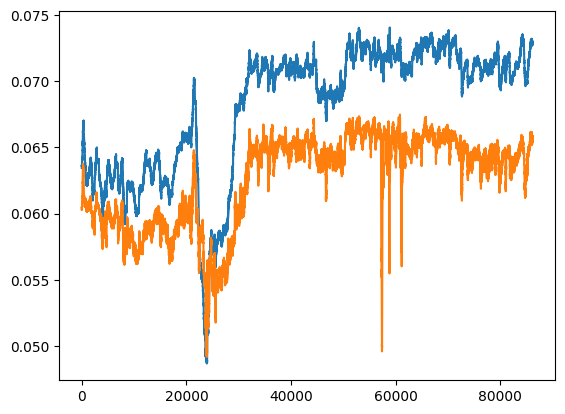

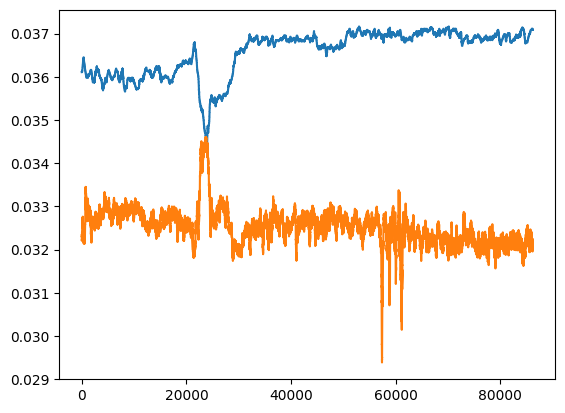

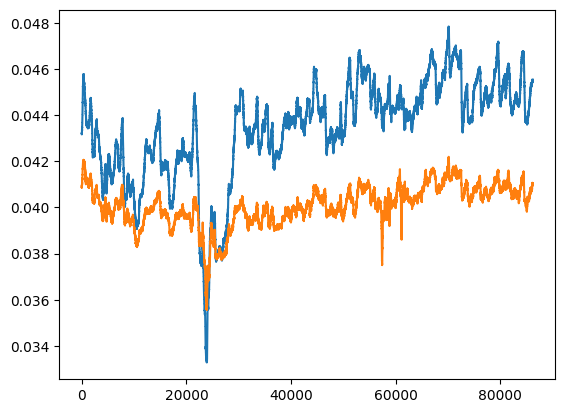

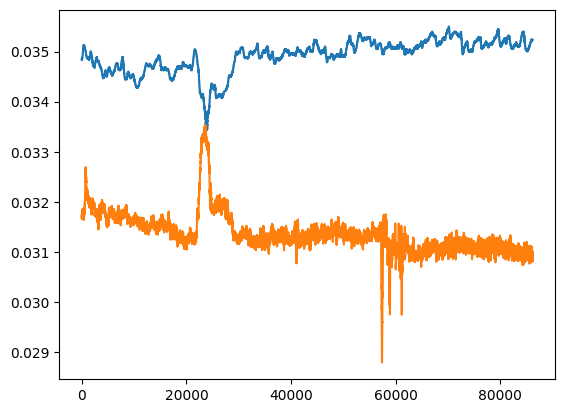

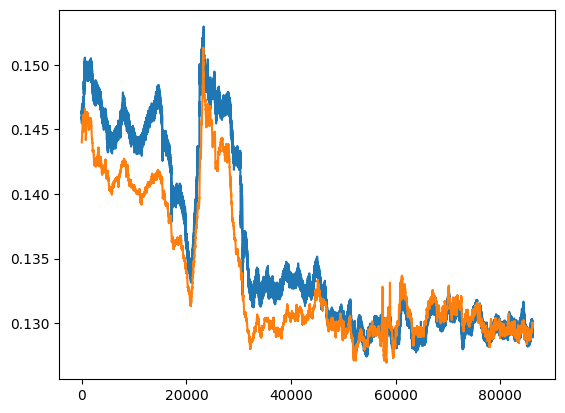

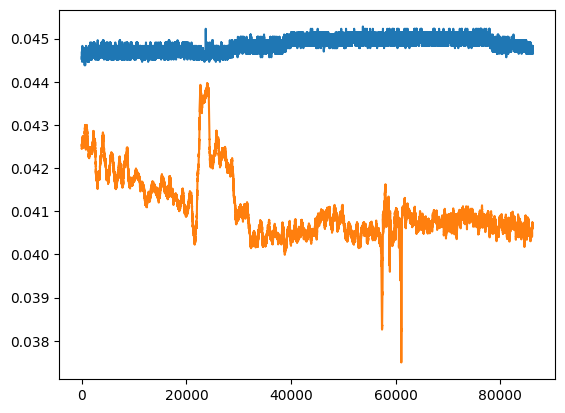

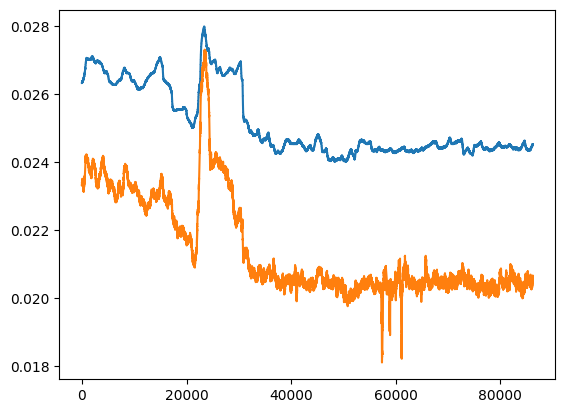

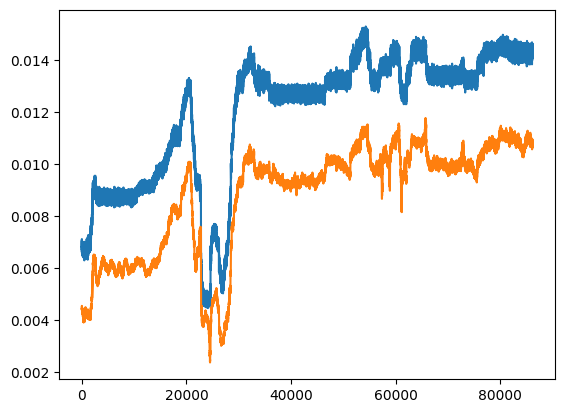

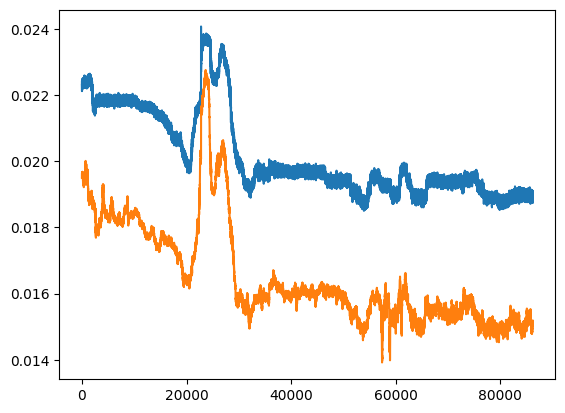

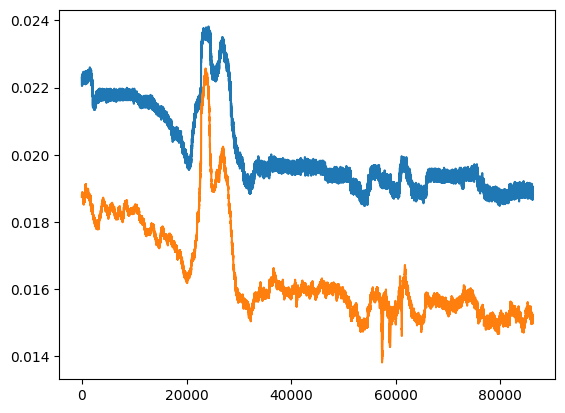

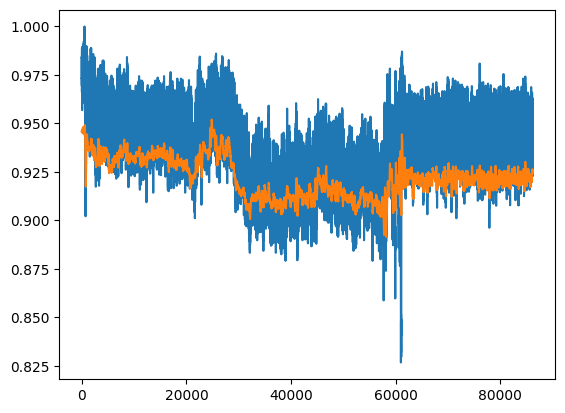

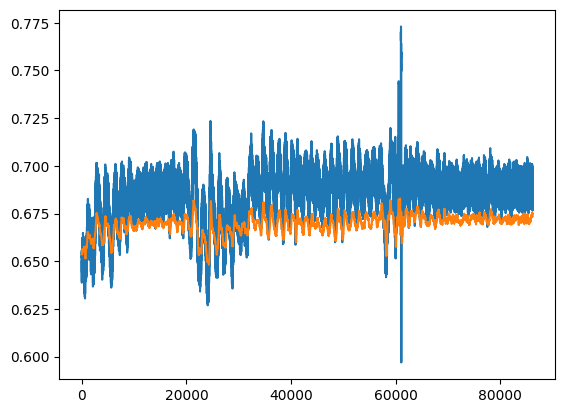

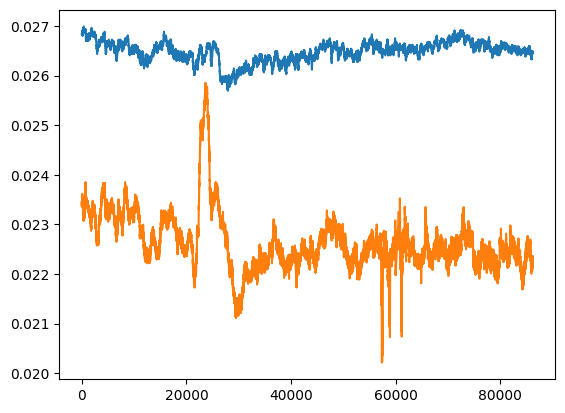

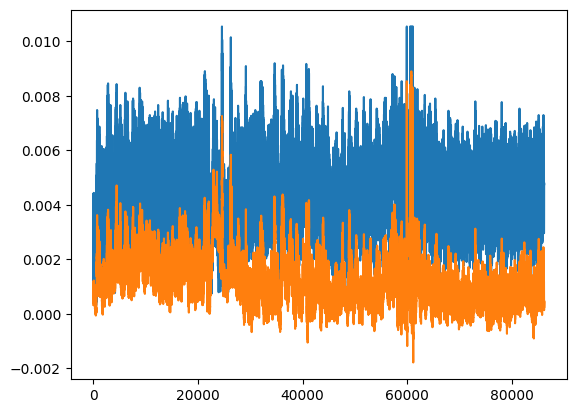

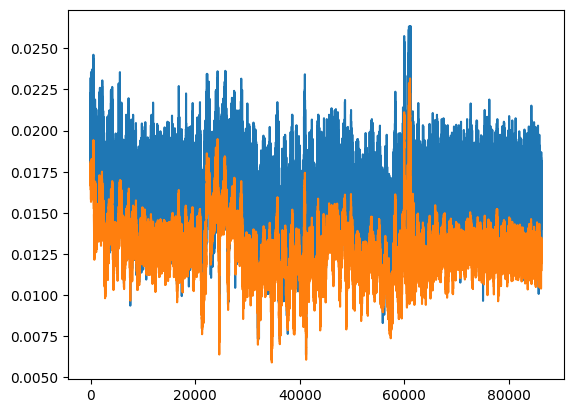

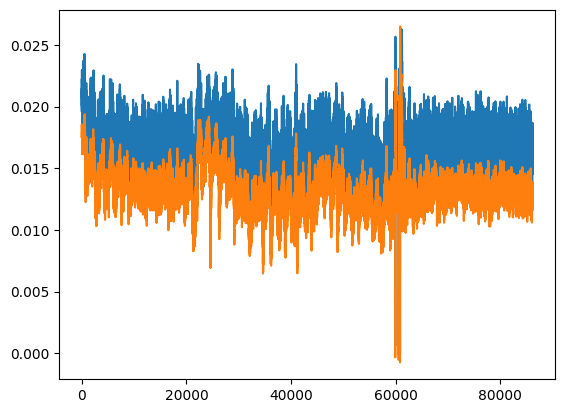

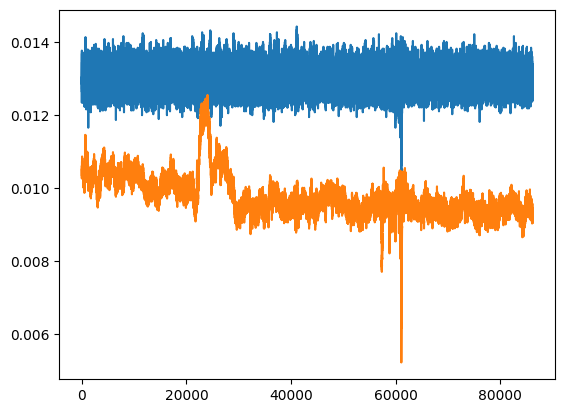

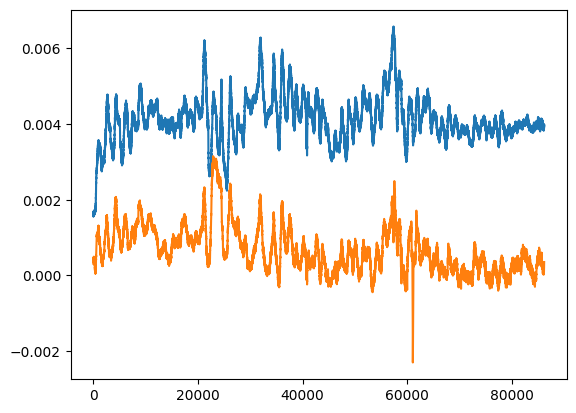

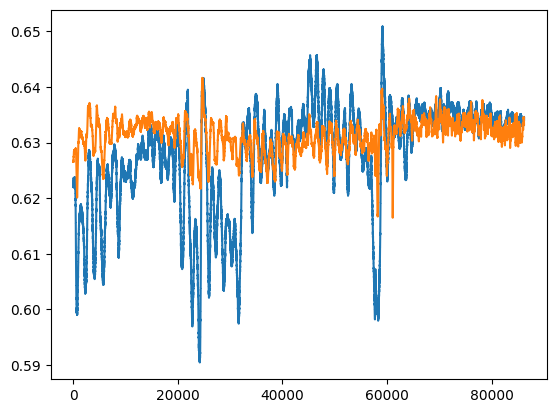

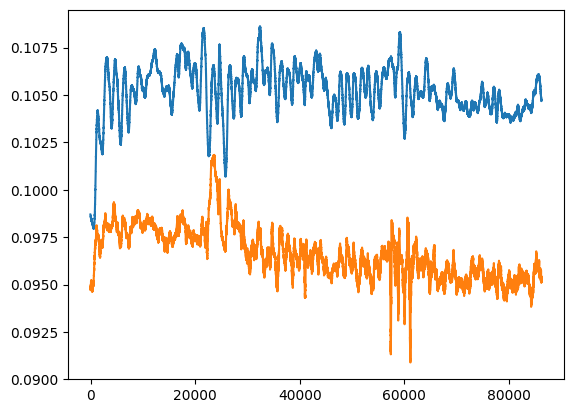

In [9]:
# With Feature GAT only
import matplotlib.pyplot as plt

for i in range(window.shape[1]):
    plt.plot(targets[:-100,i])
    plt.plot(preds[:-100,i])
    plt.show()